## Pipeline Level 4: Actionable Analysis ##
Generates basic actionable insight from the predictions. Invokes a simple action Model, if predicted prices rise, recommend Buy, Prices that are predicted to fall are marked as sell. There is a 1% threshold that ignores Buy/Sell actions unless the proces is predicted to rise or fall by 1%.

The up/down vertical lines are the reference buy/sell actions. The red arrows are good predictions, Xs indicated missed predictions.

Predictions are based on a simplay majority voting metric between the TF-IDF, Stocks Only and a Combined TF-IDF/Stocks Model.


In [13]:
# Packages
import numpy as np
import pandas as pd
#import seaborn as sn
import matplotlib.pyplot as plt
import datetime
#from All_data_muduo import df,f1
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
#//*** Maximize columns and rows displayed by pandas
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns',20 )

In [14]:
def get_mean_error(predictions, actuals):
    mean_error = (sum(predictions) - sum(actuals))/len(actuals)
    return mean_error

#//*** Basic Profit loss calculator
def calc_pl(input_df,col_actual,col_action,col_predict,threshold=0):
    
    #df = input_df[[actual,action]]
    pl = input_df.iloc[0][col_actual]
    pl = 0
    
    #//*** Negative value to reflect initial cost buy-in
    pl = input_df.iloc[0][col_actual] * -1
    #//*** Position -1 Sell, 0 Hold, 1 Buy
    position = 0
    
    current_price = input_df.iloc[0][col_actual]
    trade_threshold = input_df.iloc[0][col_actual] * threshold
    
    pl_min = 0
    pl_max = 0
    for row in input_df.iterrows():
        
        price = row[1][col_actual]
        action = row[1][col_action]
        predict = row[1][col_predict]
        
        #//*** Check if price movement is greater than the trade threshold
        #//*** We only want to make a move if the price difference is greater than threshold (.01 default) in either direction
        #print(trade_threshold,abs(price-predict))
        
        if trade_threshold > abs(current_price-predict):
            #//*** Below Threshold skip action
            position = 0
            #print(f"Below Threshold: {current_price} <> {trade_threshold} <> {predict}")
            continue
    
        #//Buy Hold Sell
        if action == 0:
            #print("Sell: ",pl,position,row[1][col_actual],row[1][col_action])
            #//*** Prediction indicates sell
            if position == -1:
                              
                #//*** We have already sold. Stay out do nothing
                position = -1
            else:
                #//*** Holding Stock or bought stock. Convert to cash
                pl += price
                position = -1

                trade_threshold = price * threshold
                current_price = price
                #print(f"Sold: {price} - {trade_threshold}")
                
                #print(f"sold at {price} P/L: {pl} ")
        
        if action == 1:
            #print("Buy: ",pl,position,row[1][col_actual],row[1][col_action])
            #//*** Indicates buy
            if position == -1:
                #//**** We Sold, it's time to buy
                pl -= price
                position = 1

                trade_threshold = price * threshold
                current_price = price
                #print(f"buy: {price} - {trade_threshold}")

                #print(f"bought at {price} P/L: {pl} ")
        if pl > pl_max:
            pl_max = pl
        if pl < pl_min:
            pl_min = pl
        
    #return (round(pl,2),round(pl_min,2),round(pl_max,2))
    return round(pl,2)


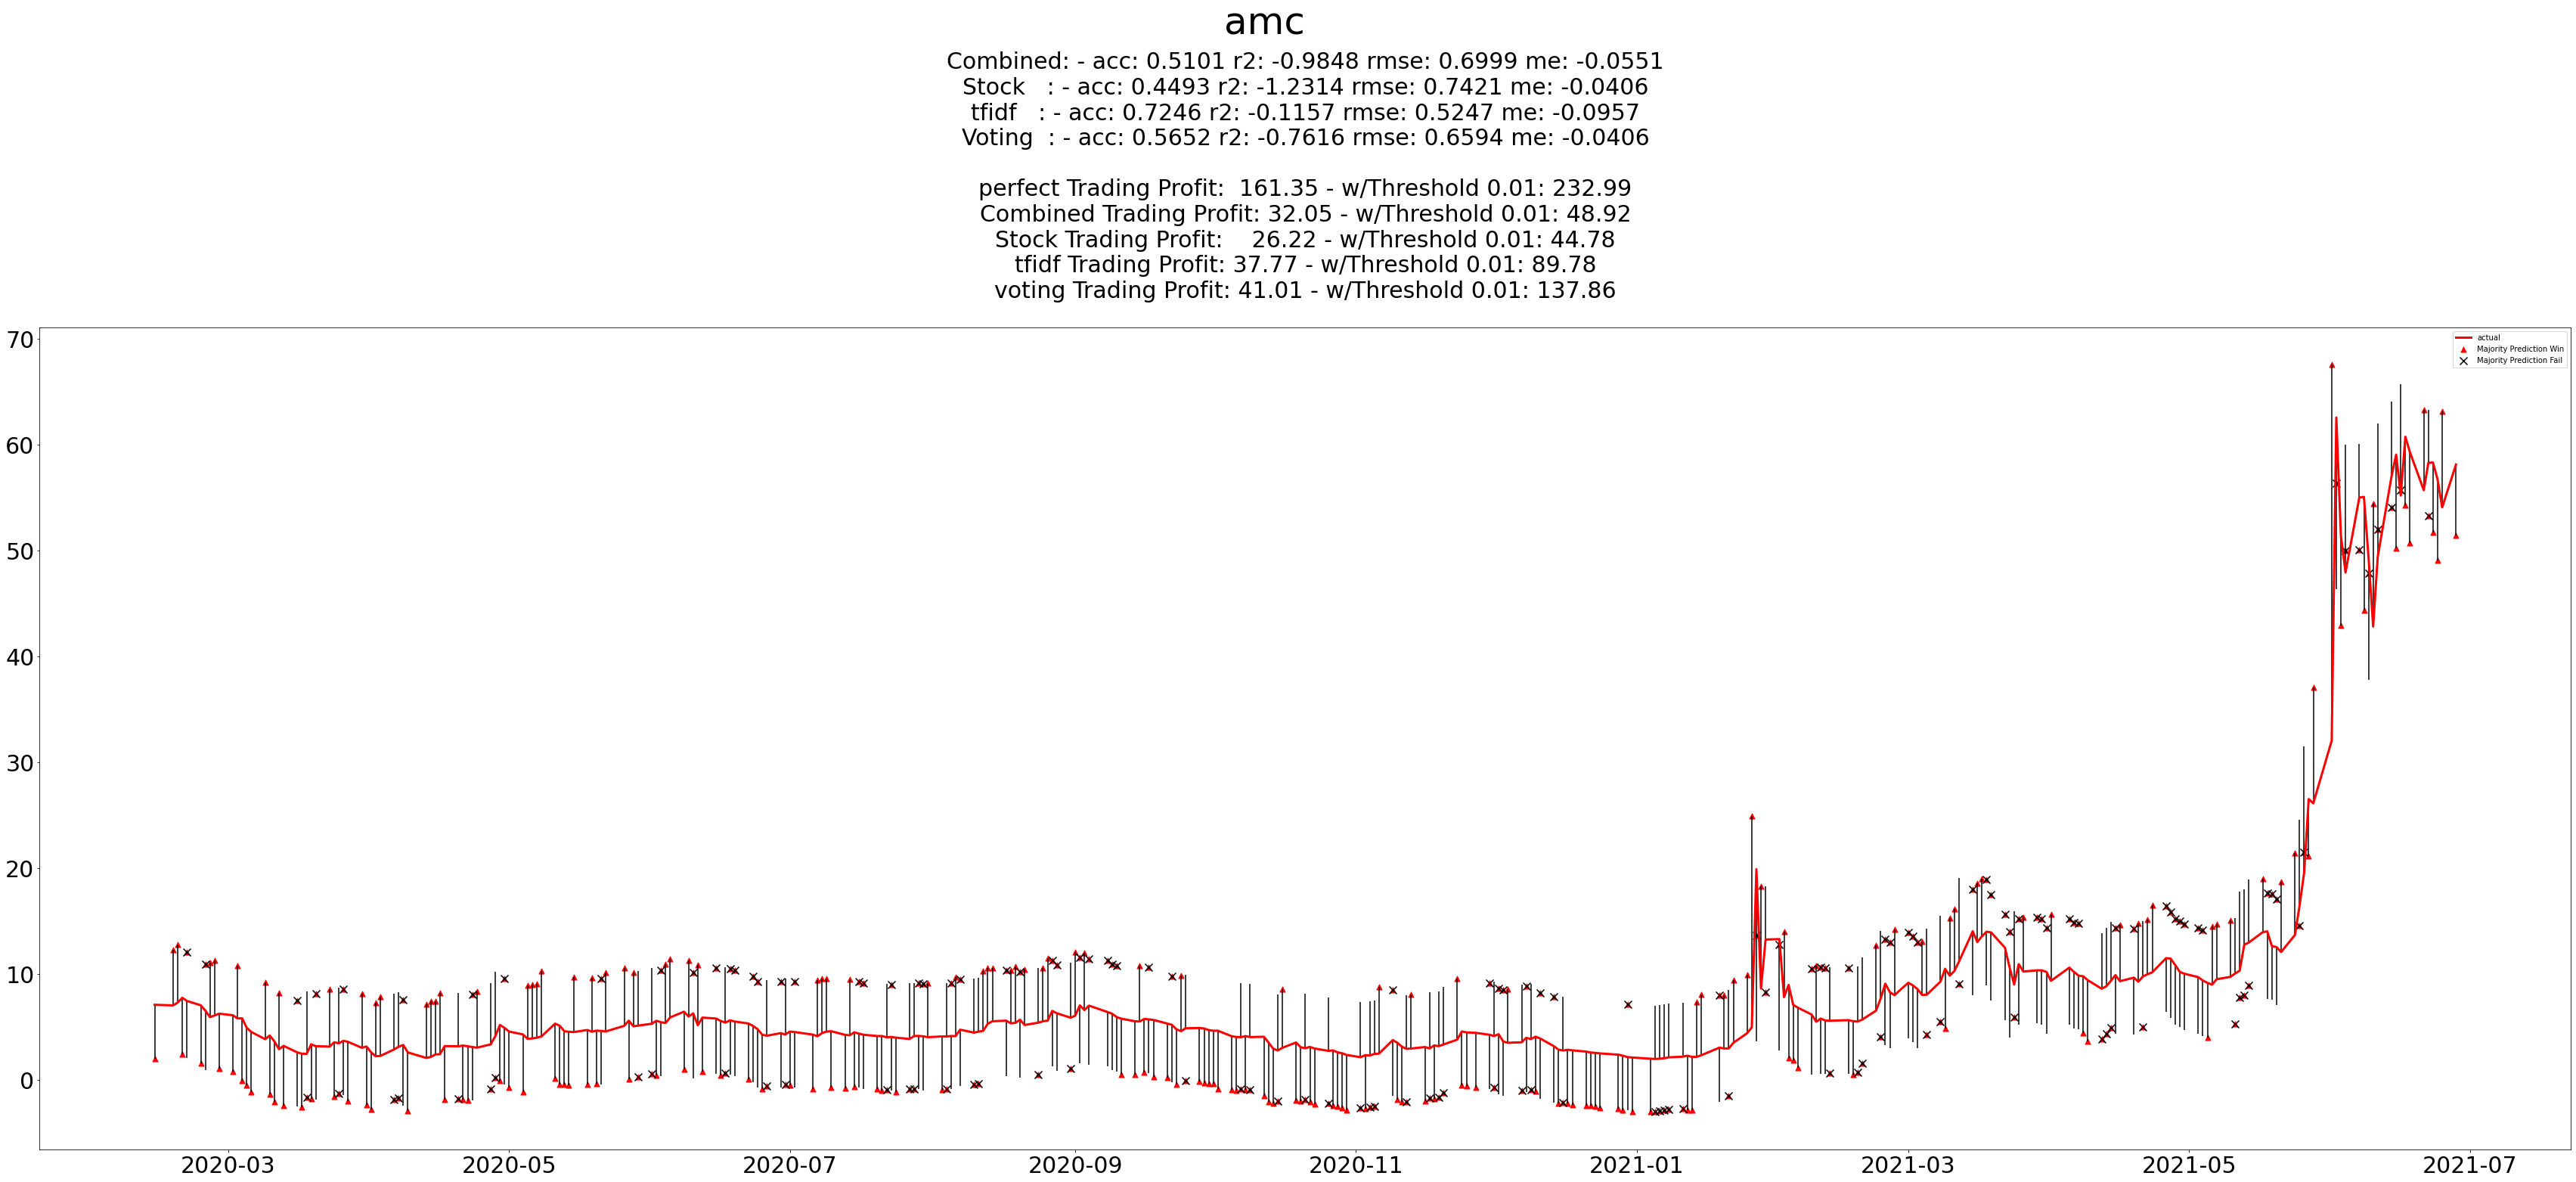

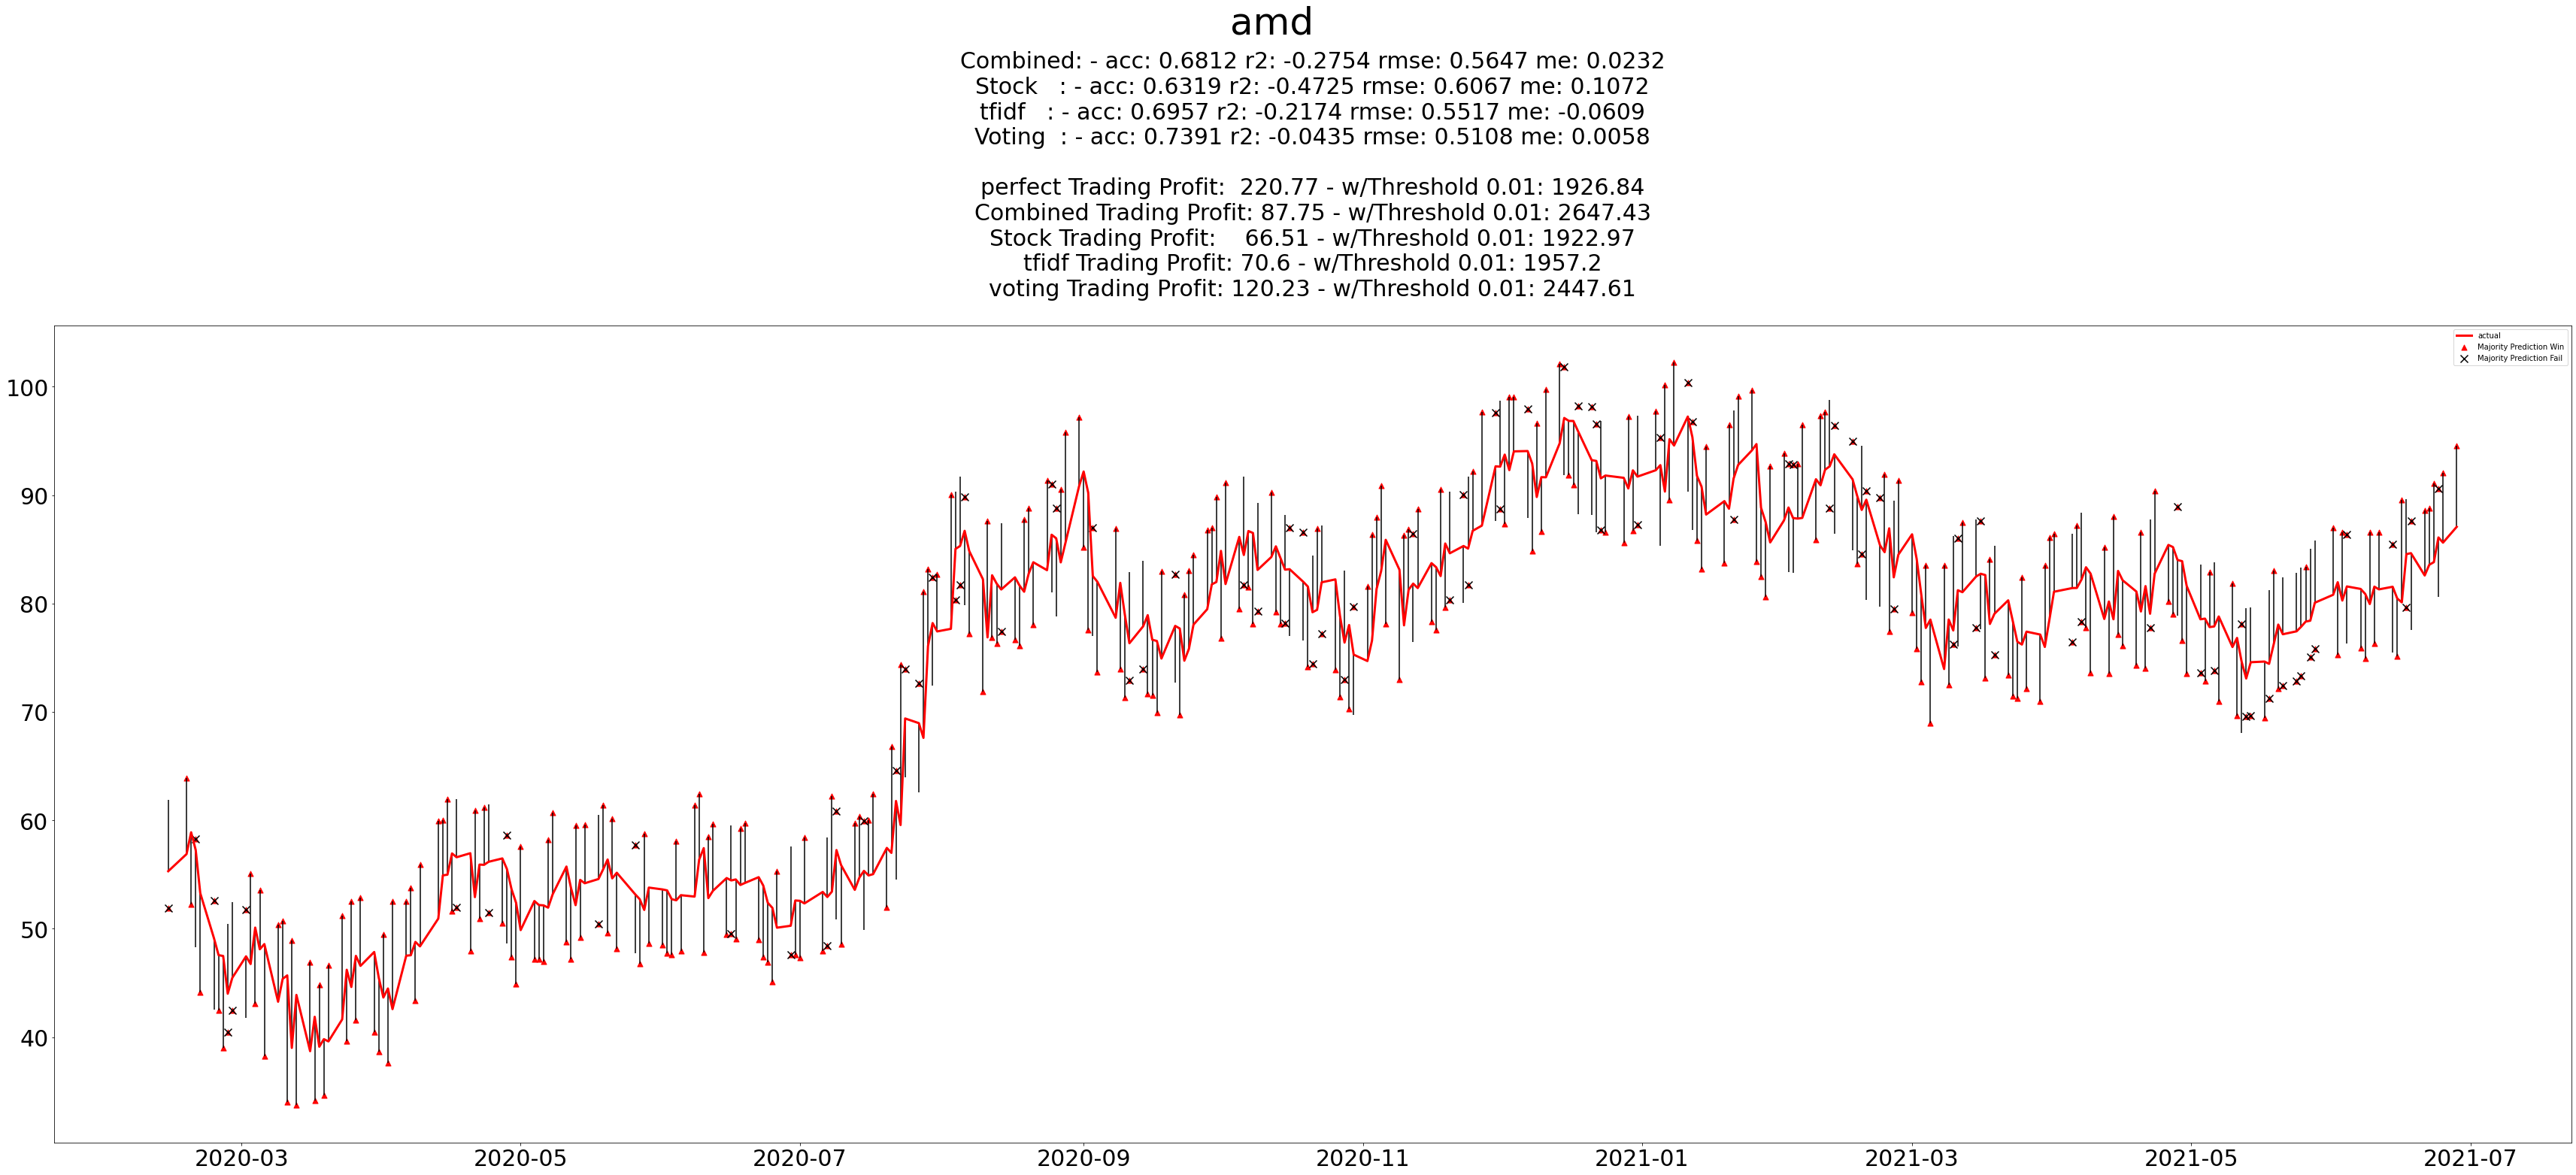

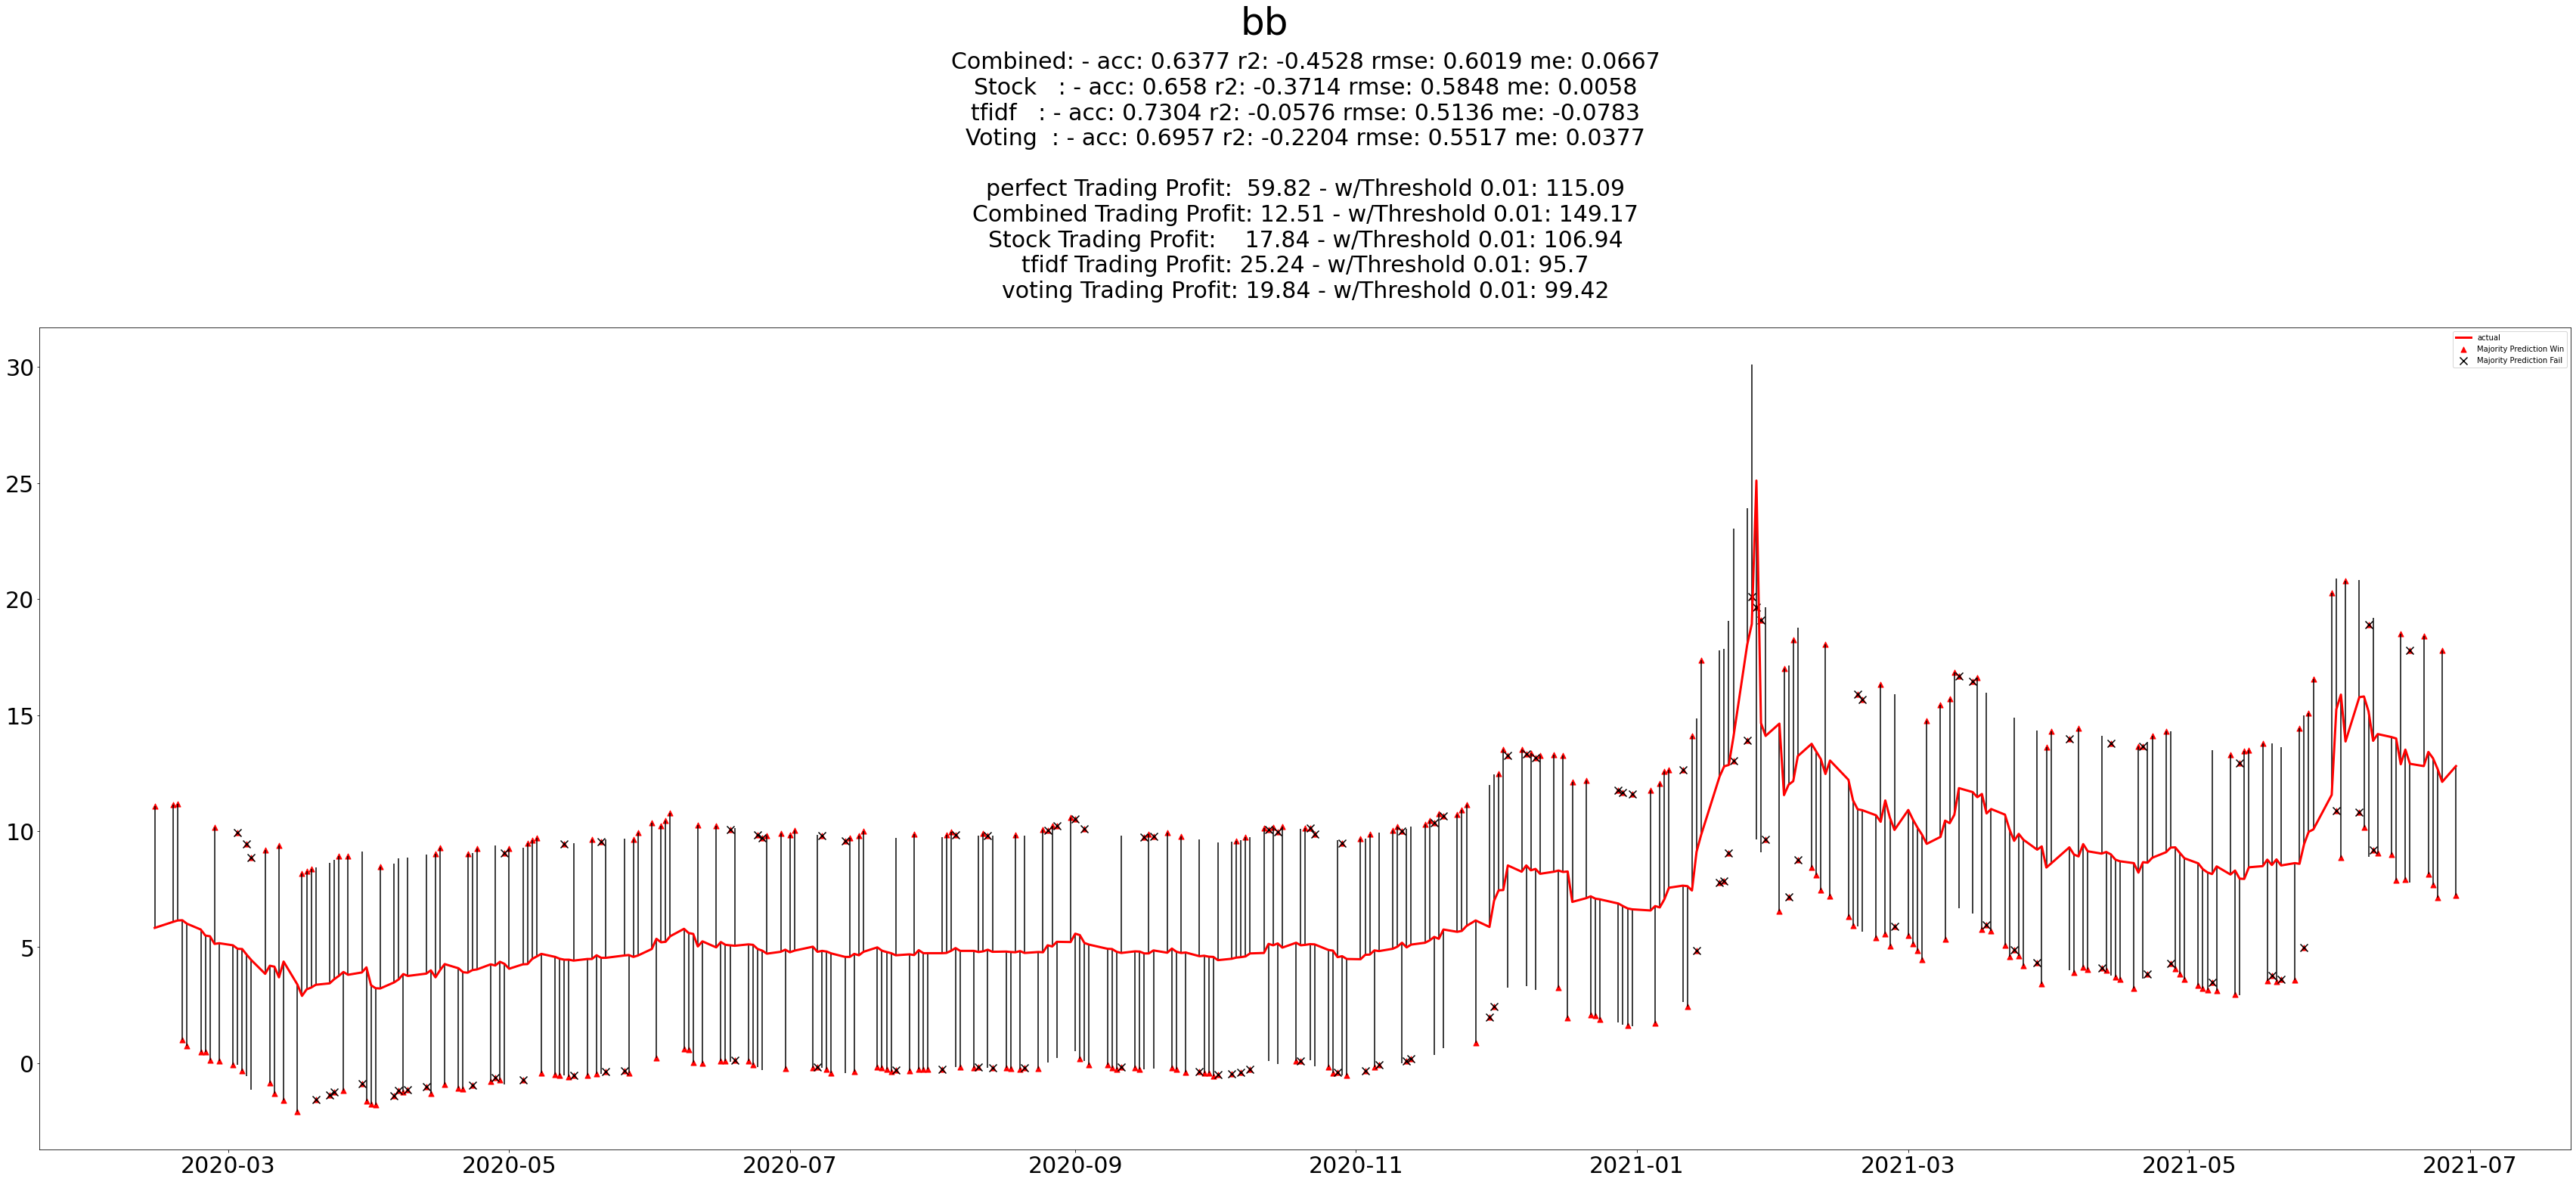

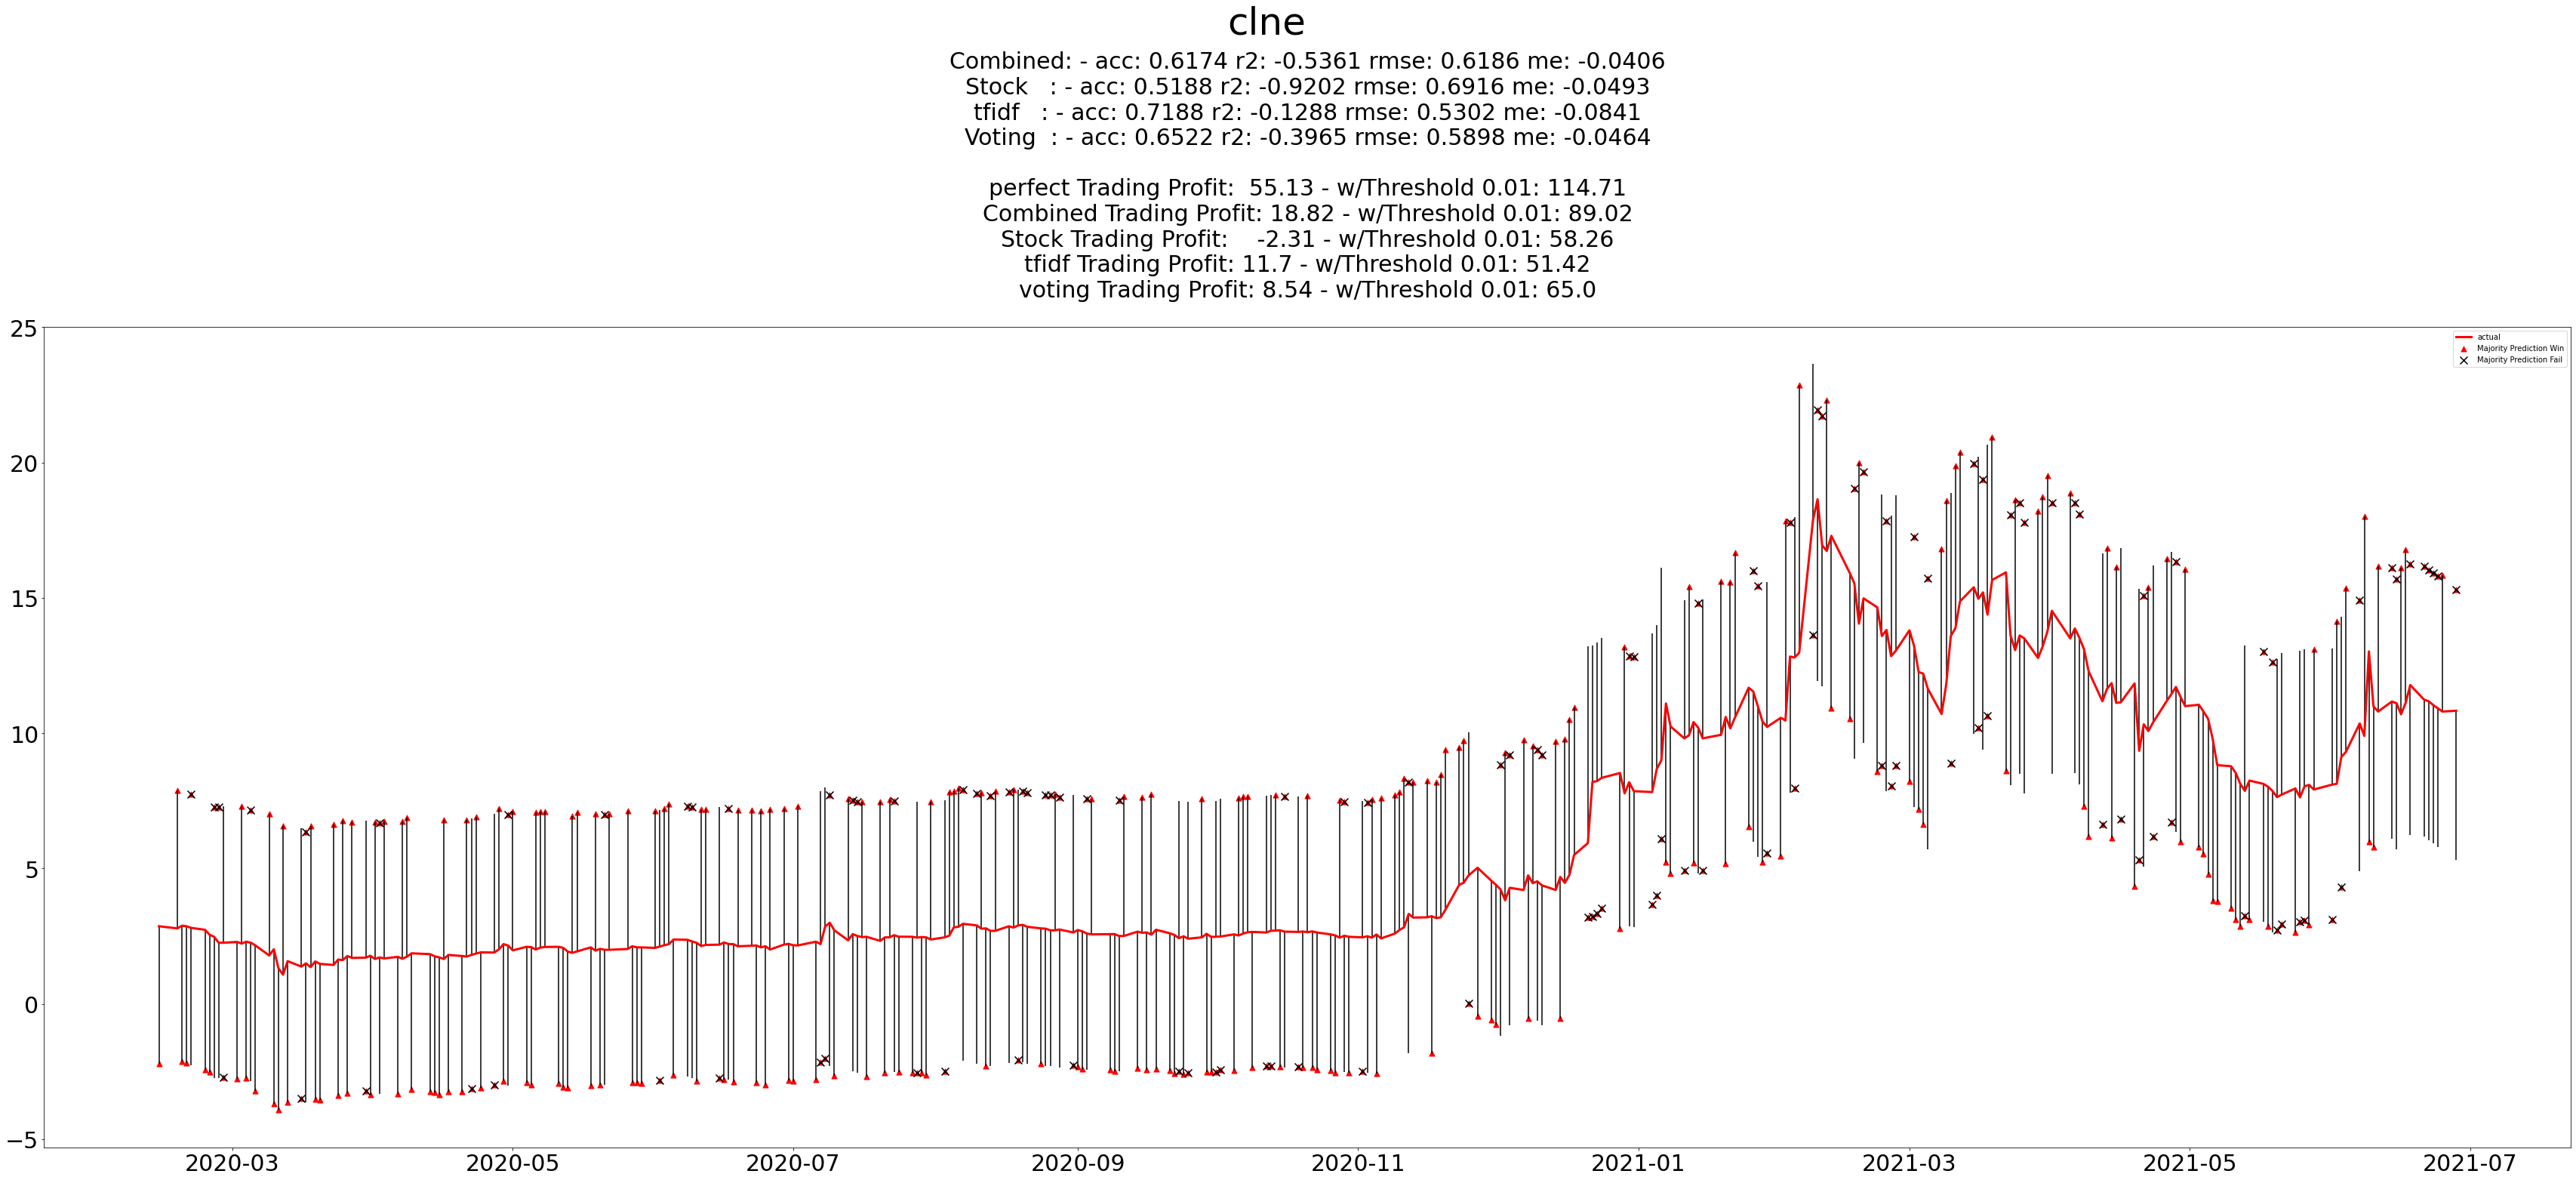

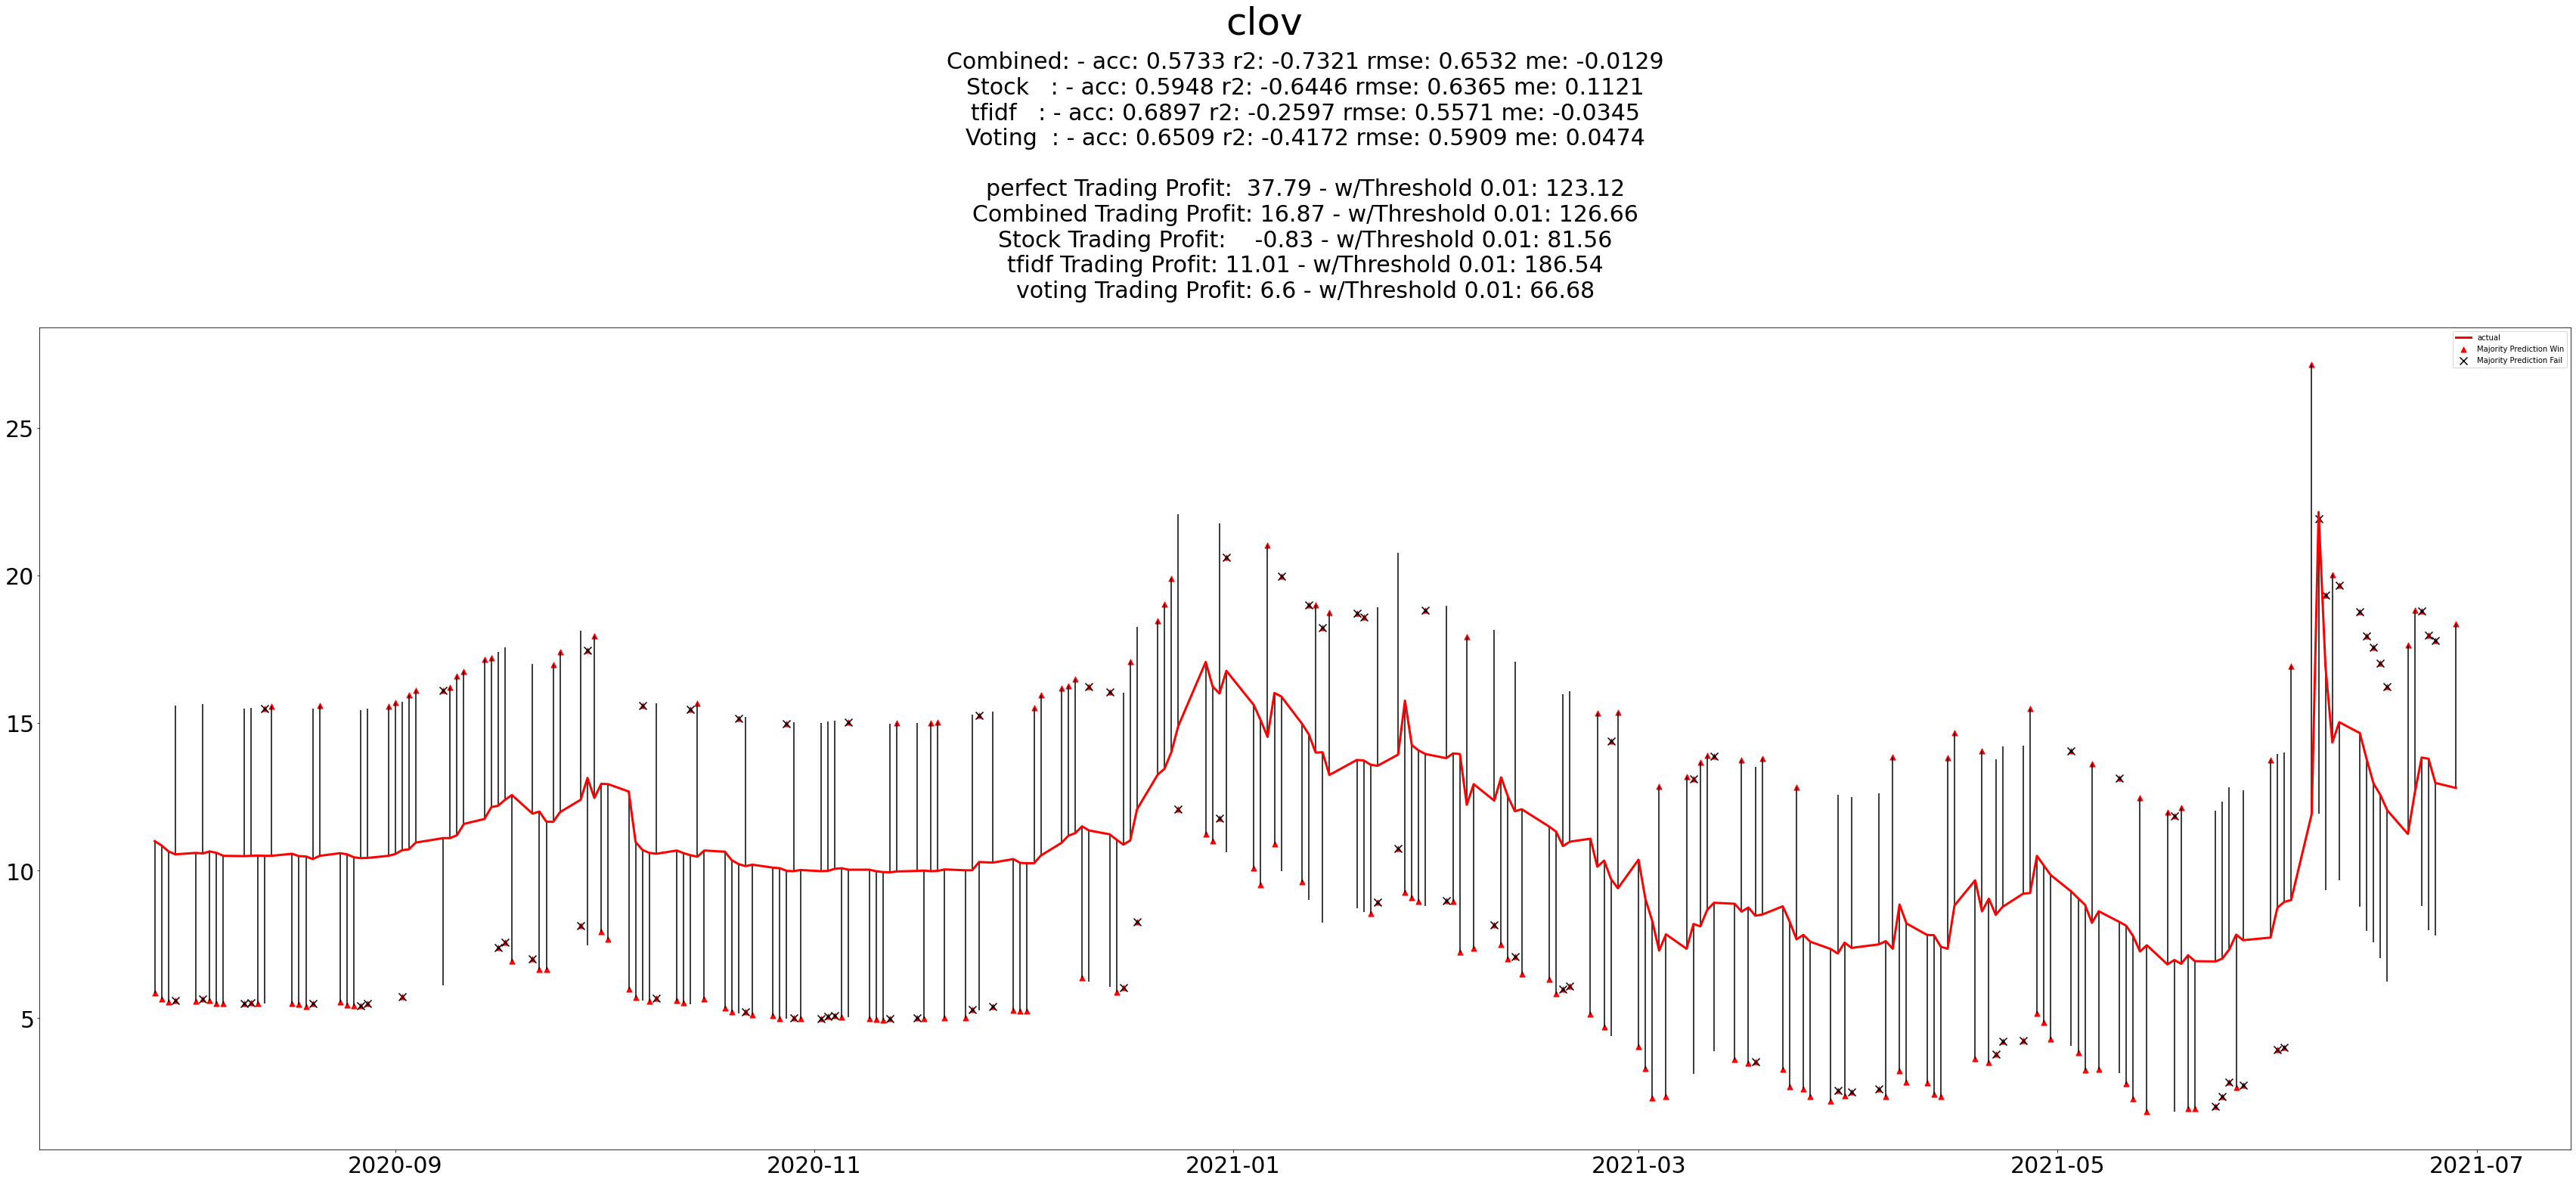

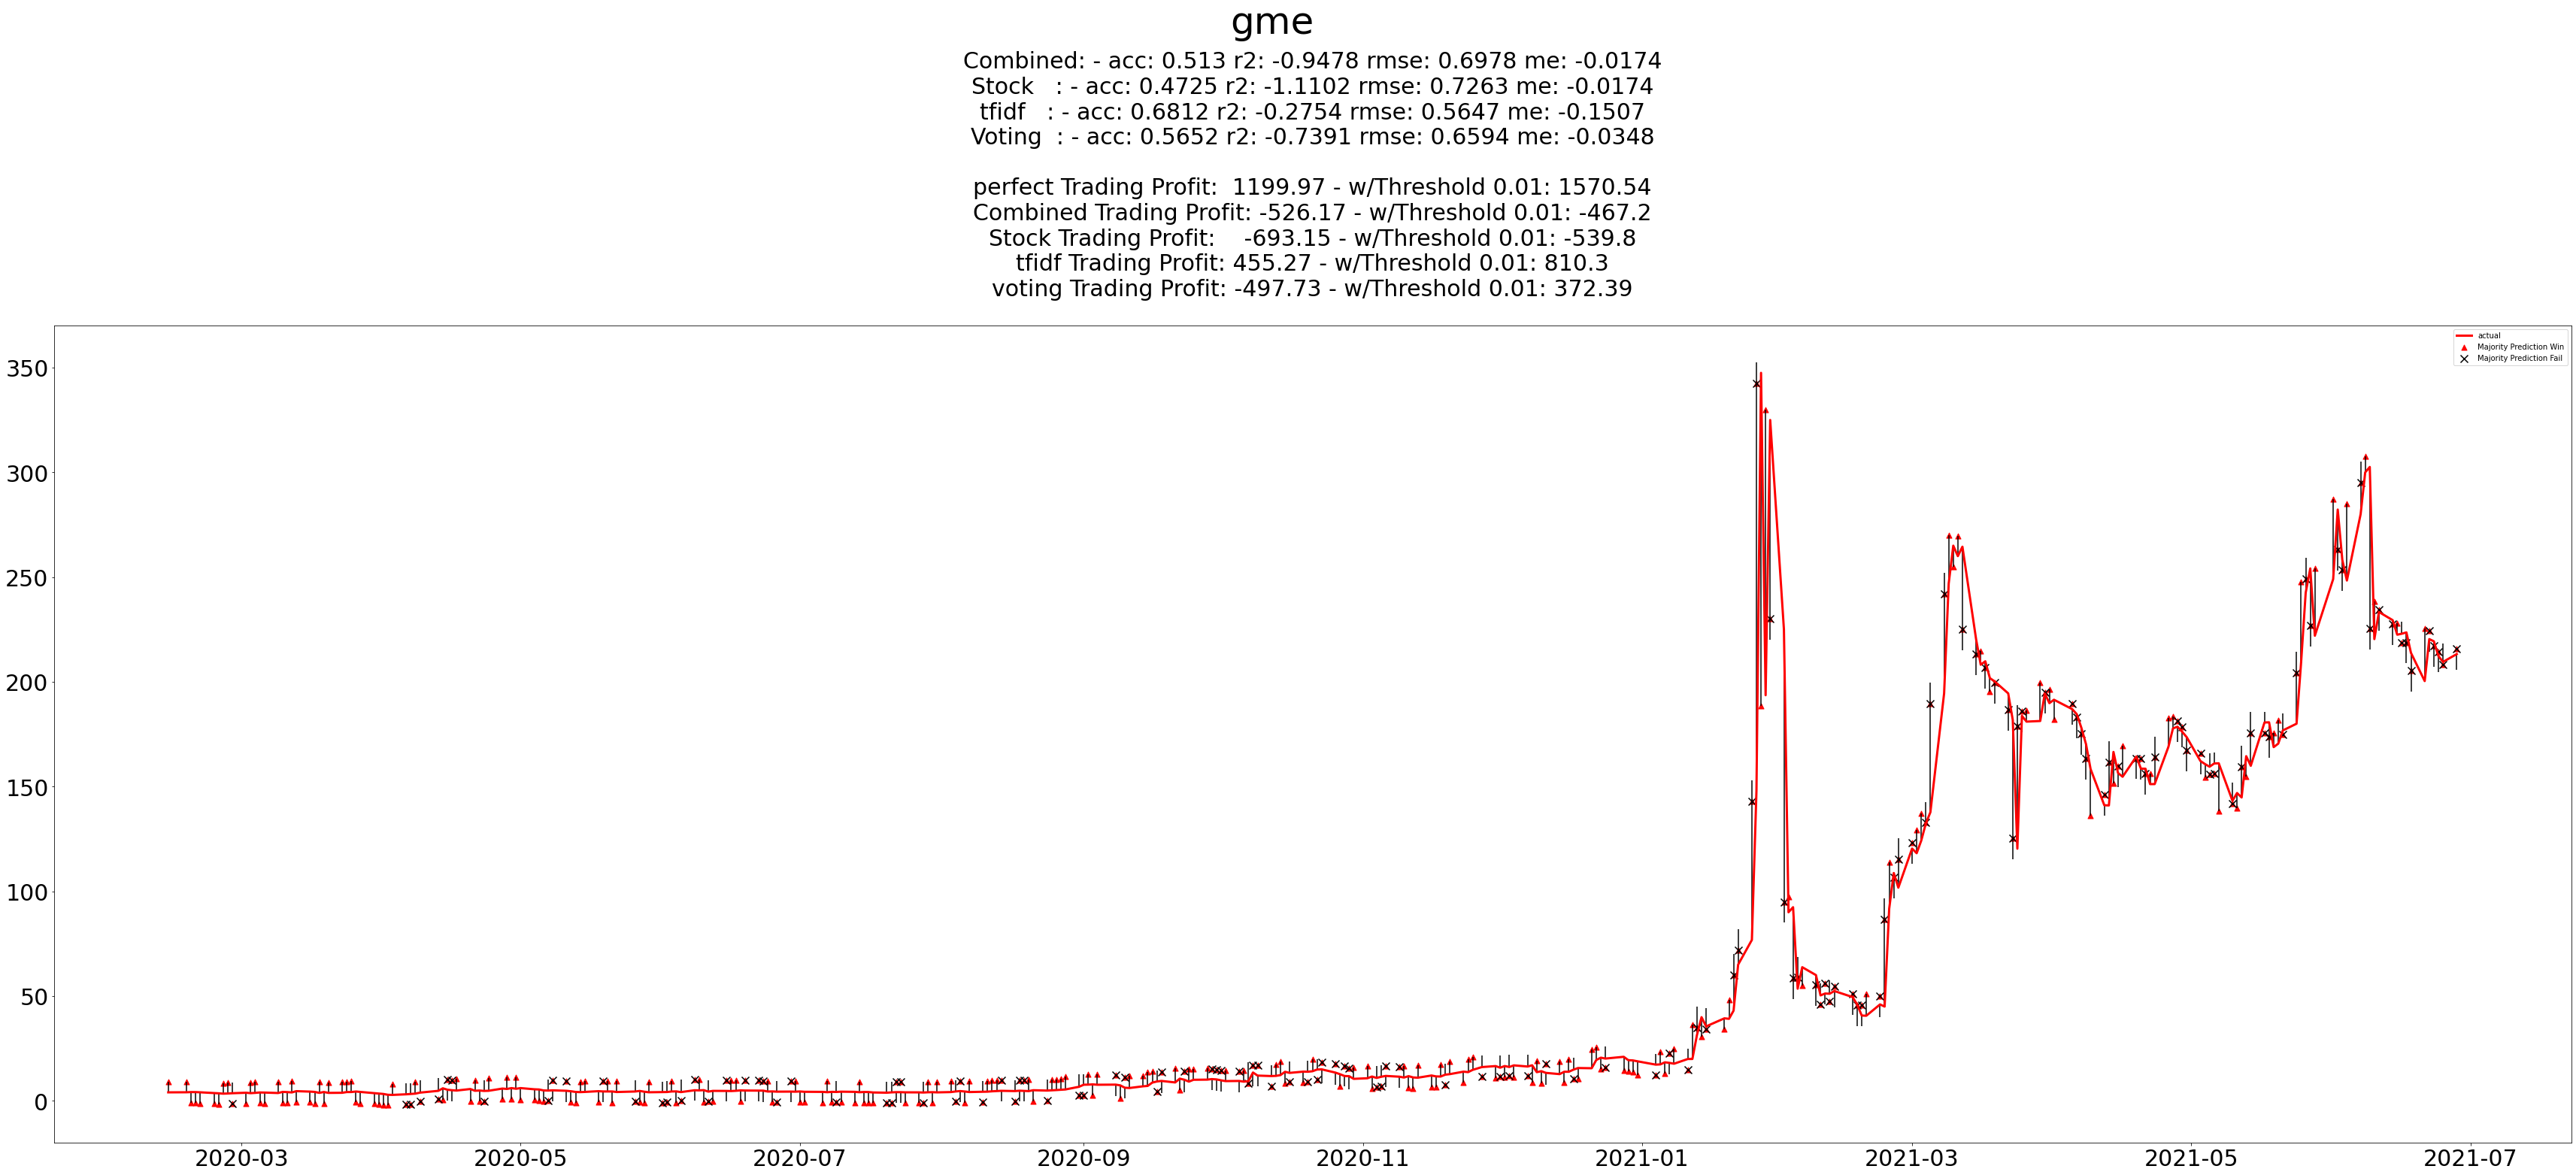

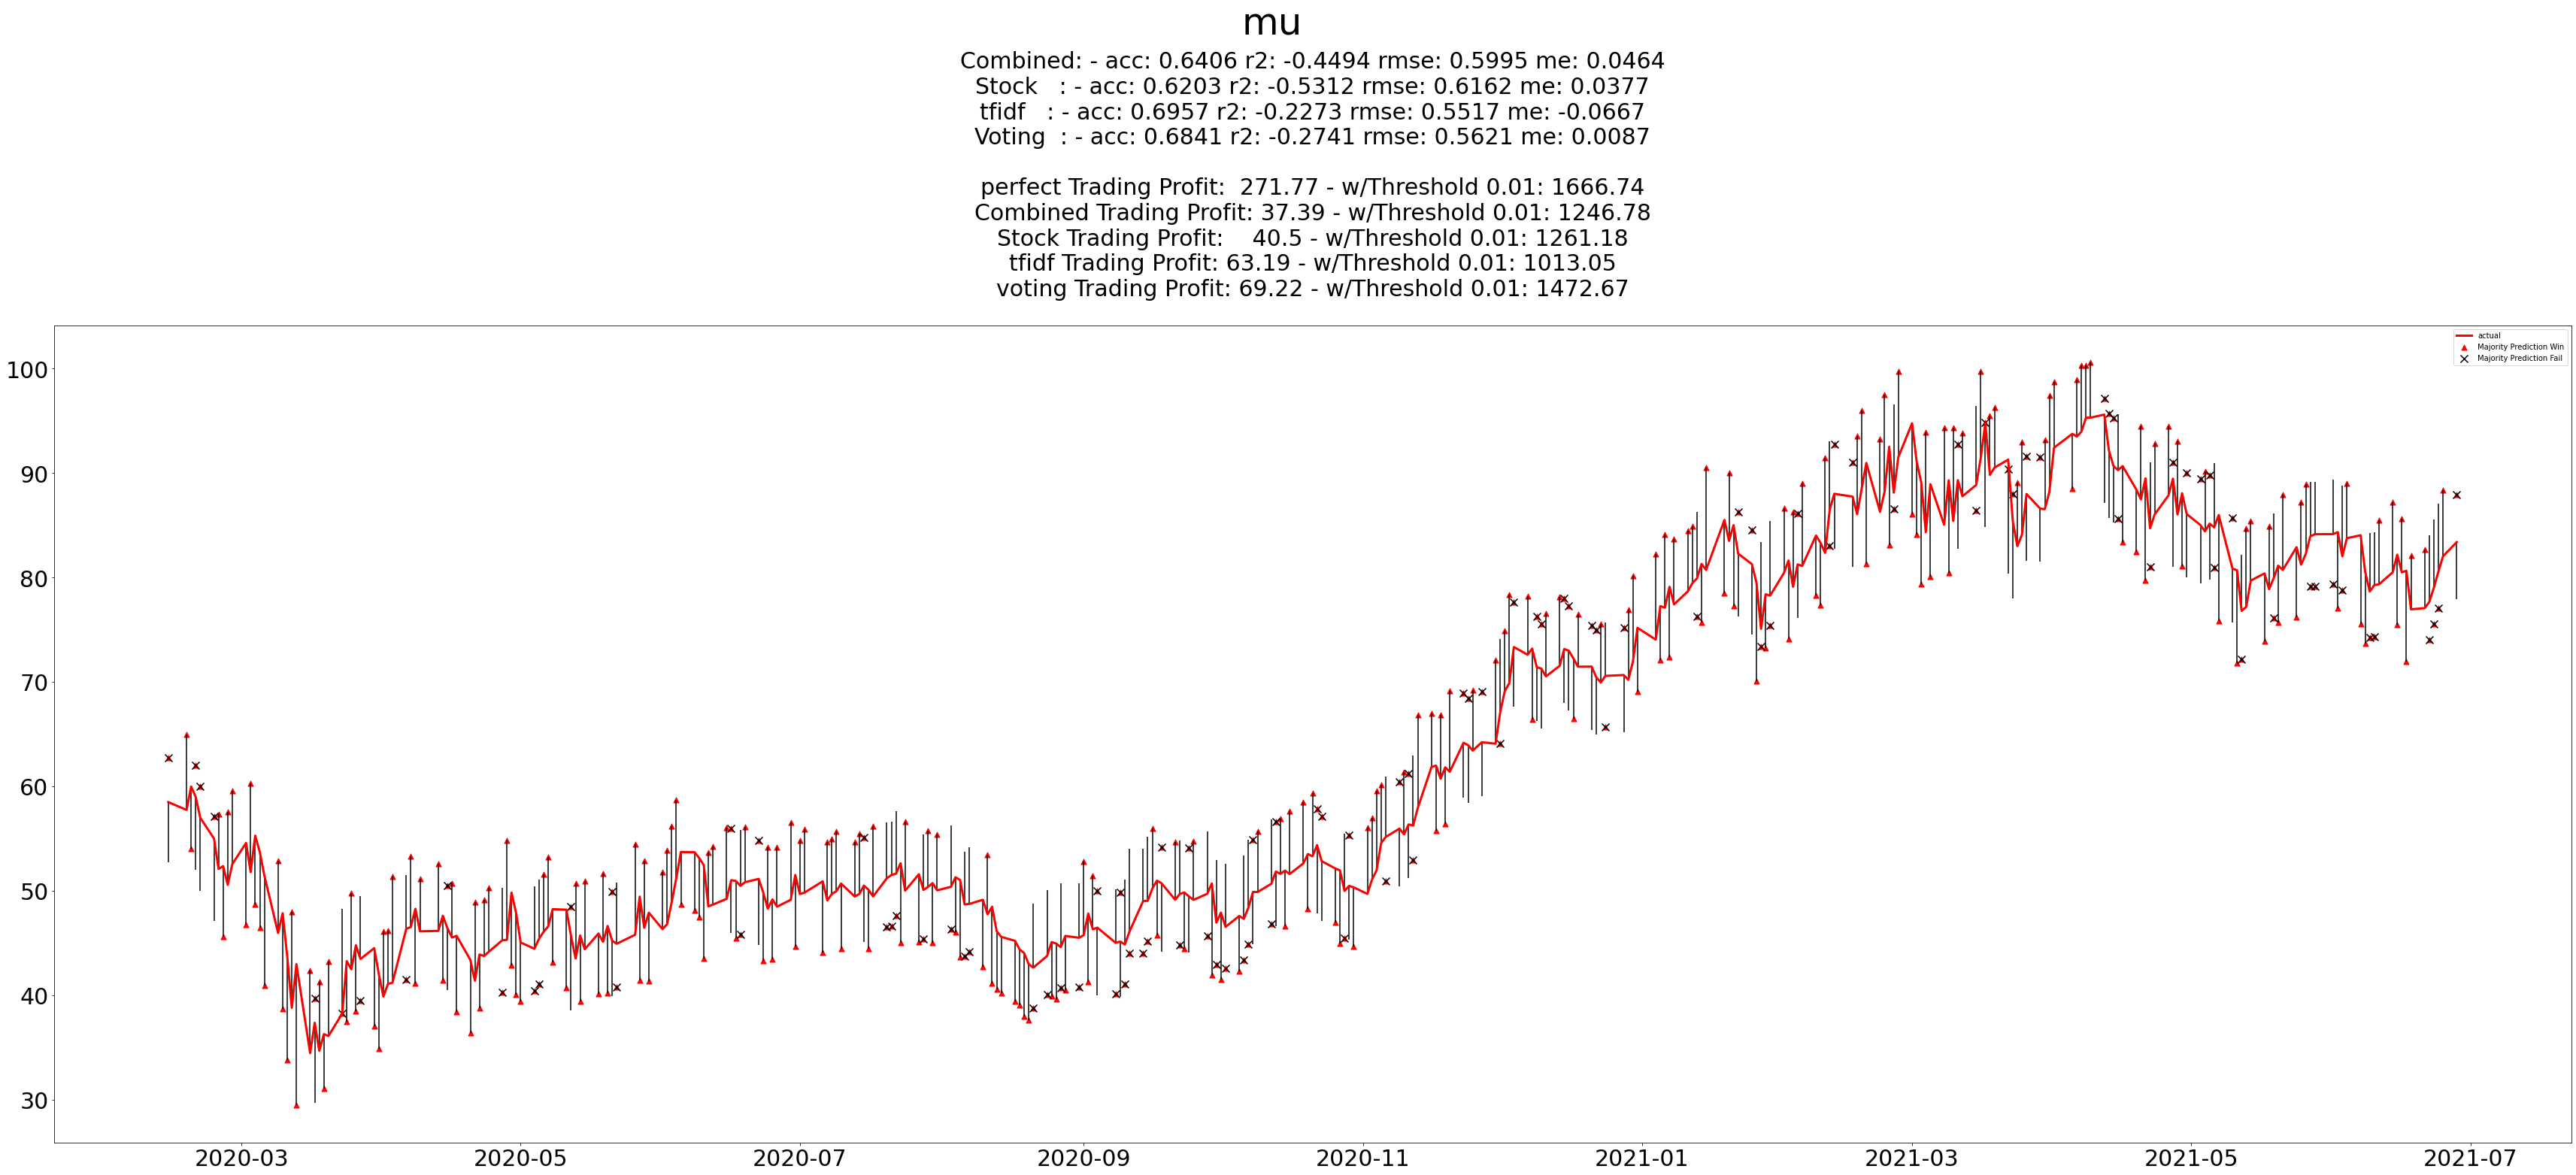

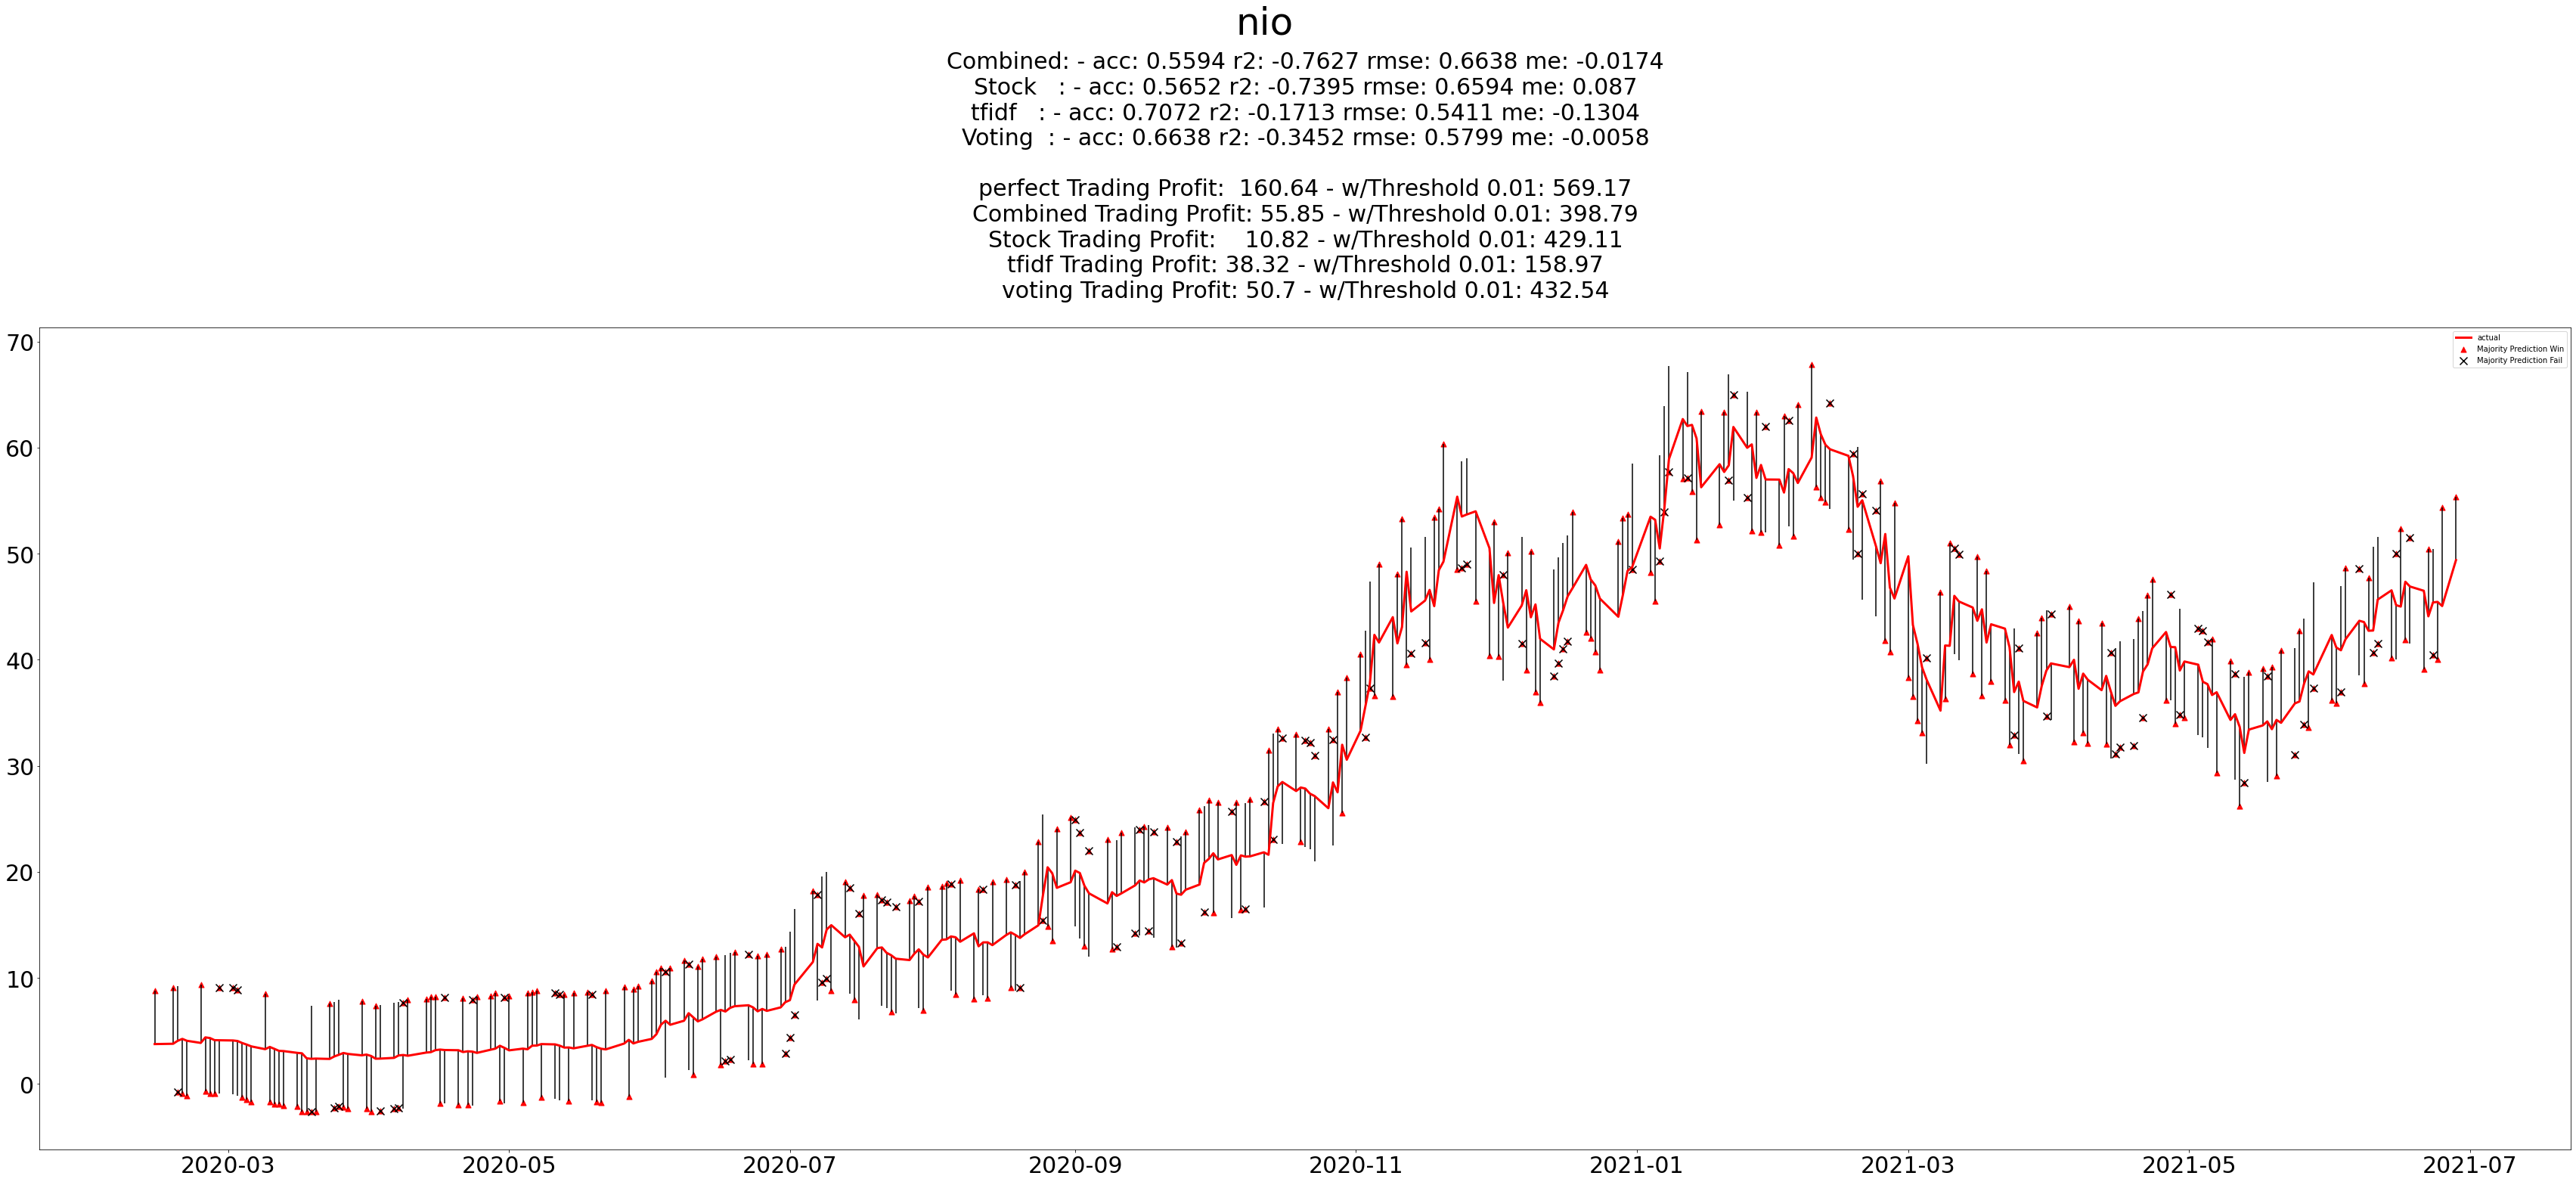

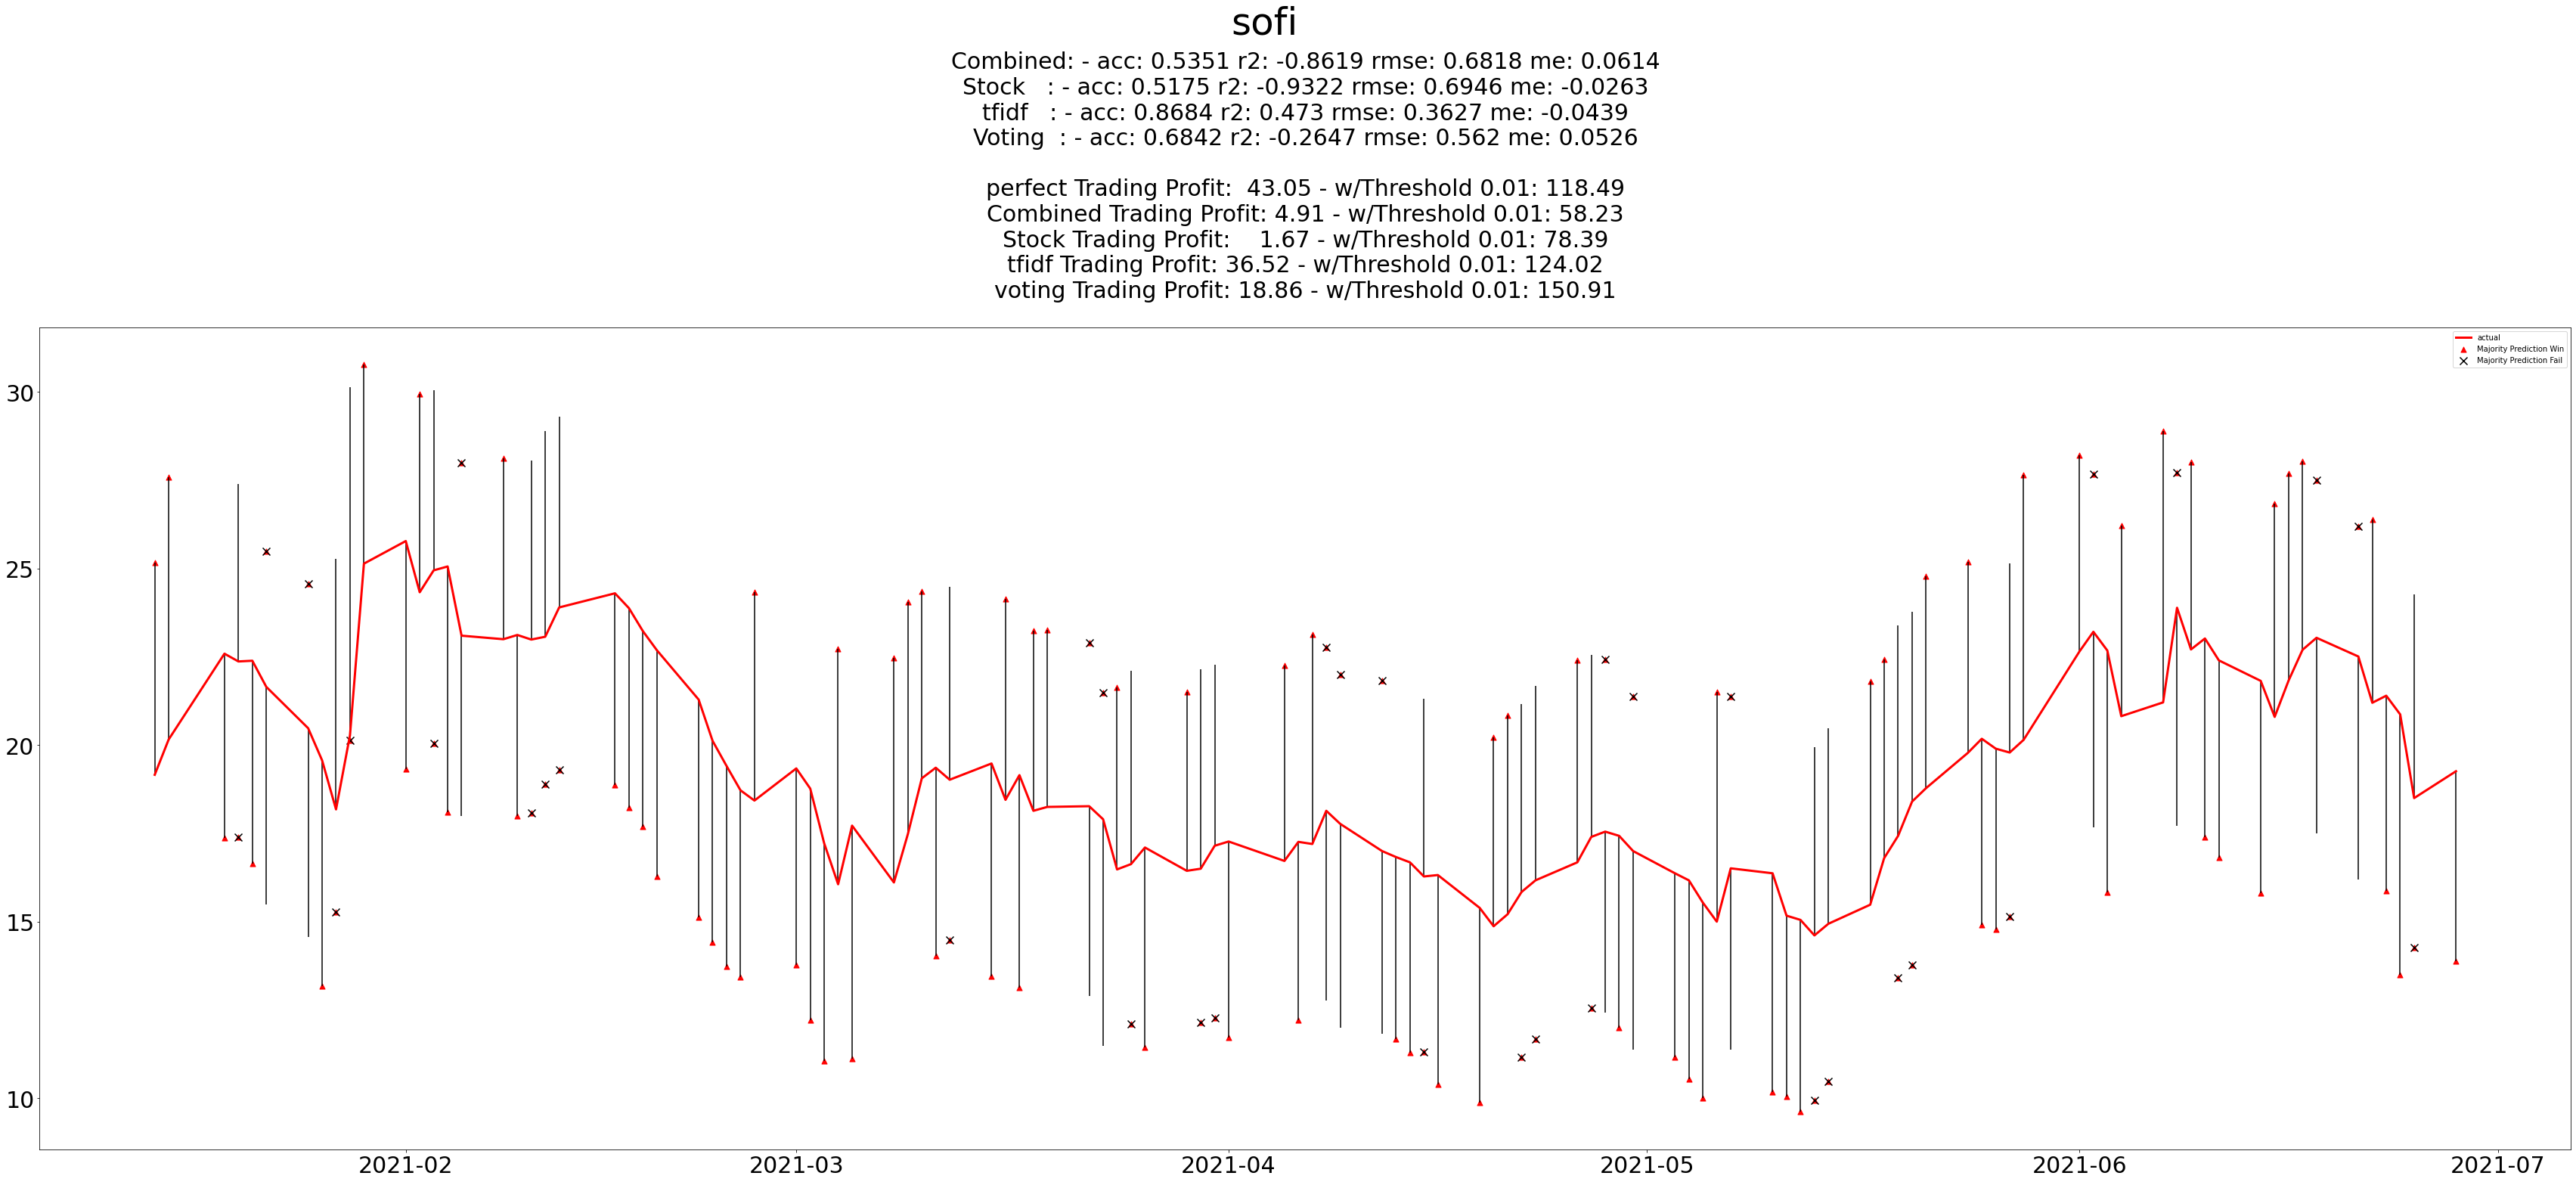

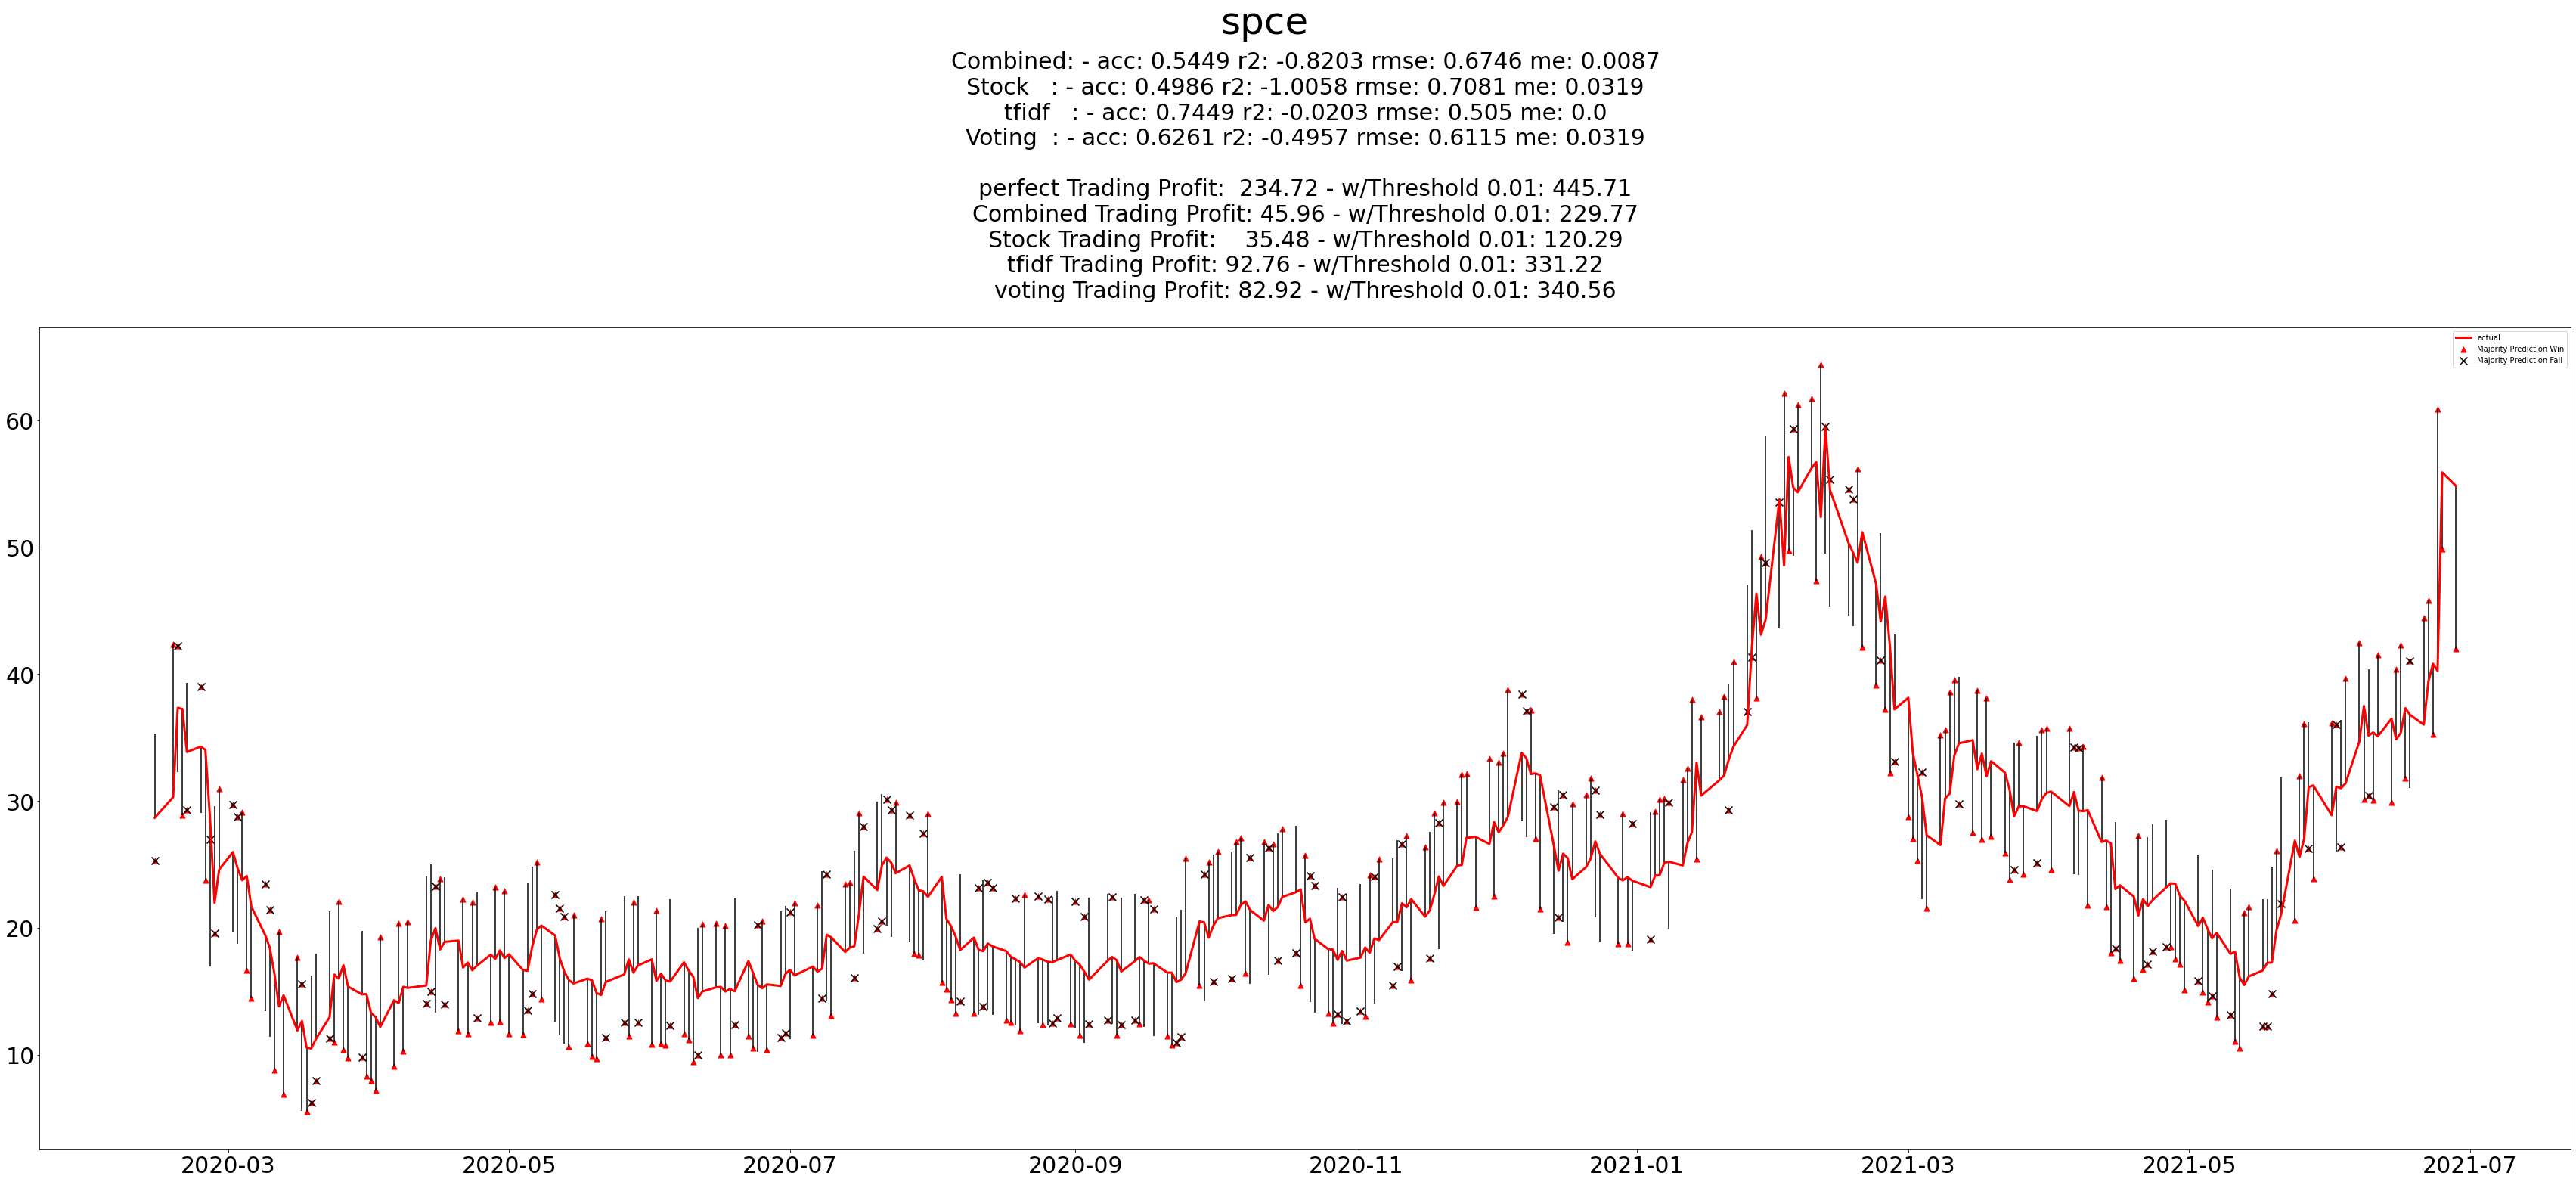

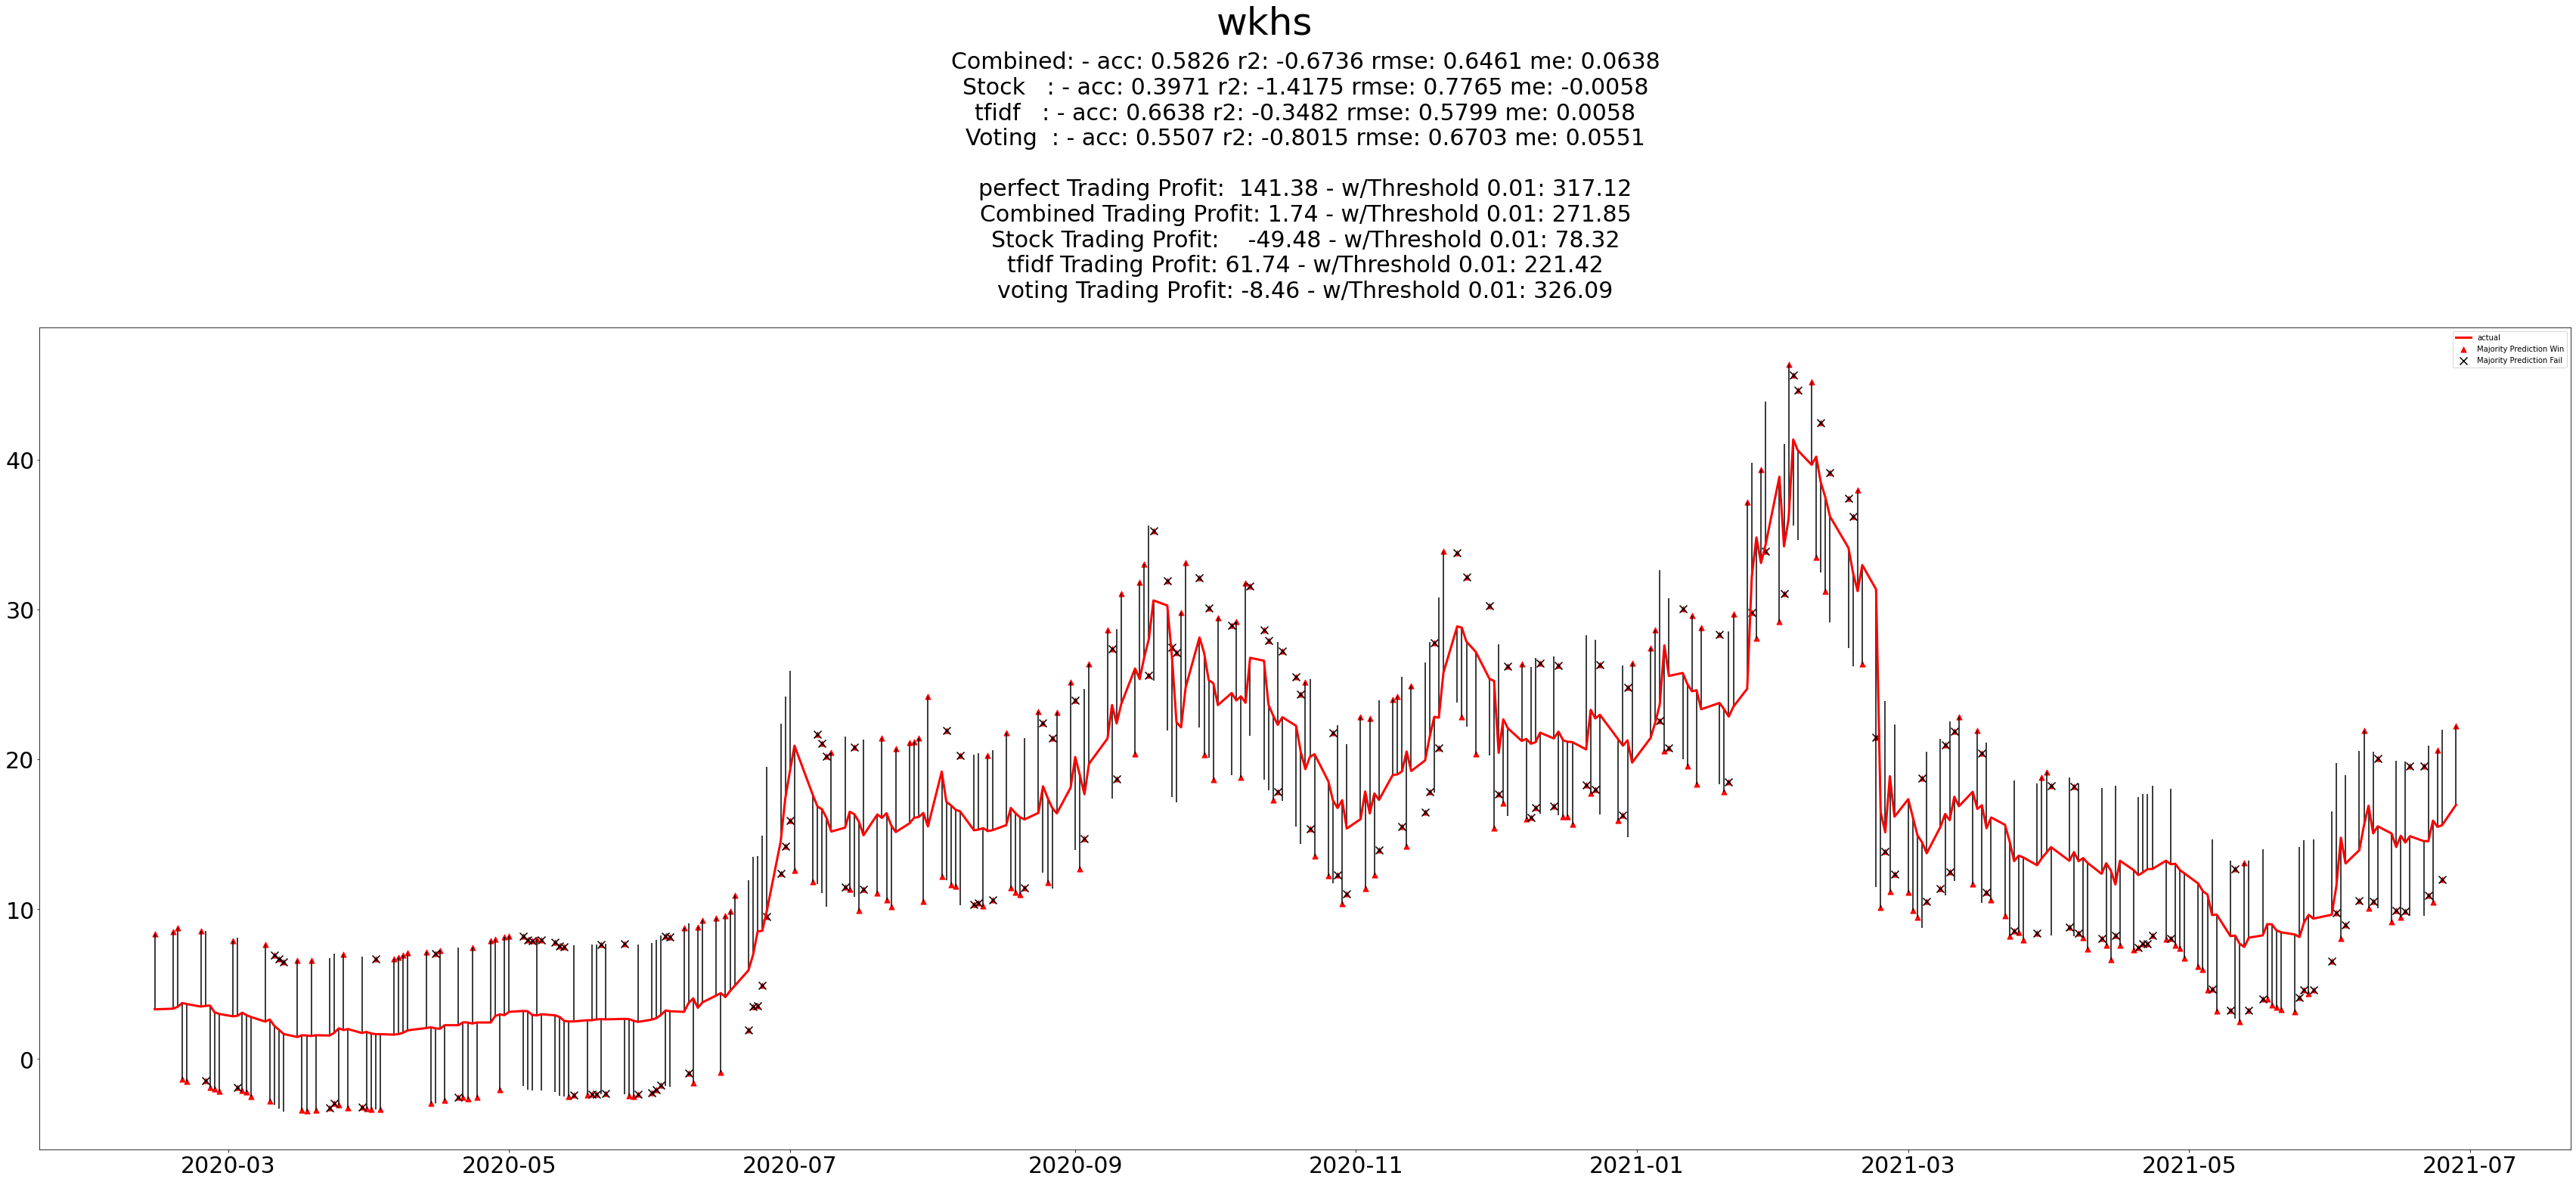

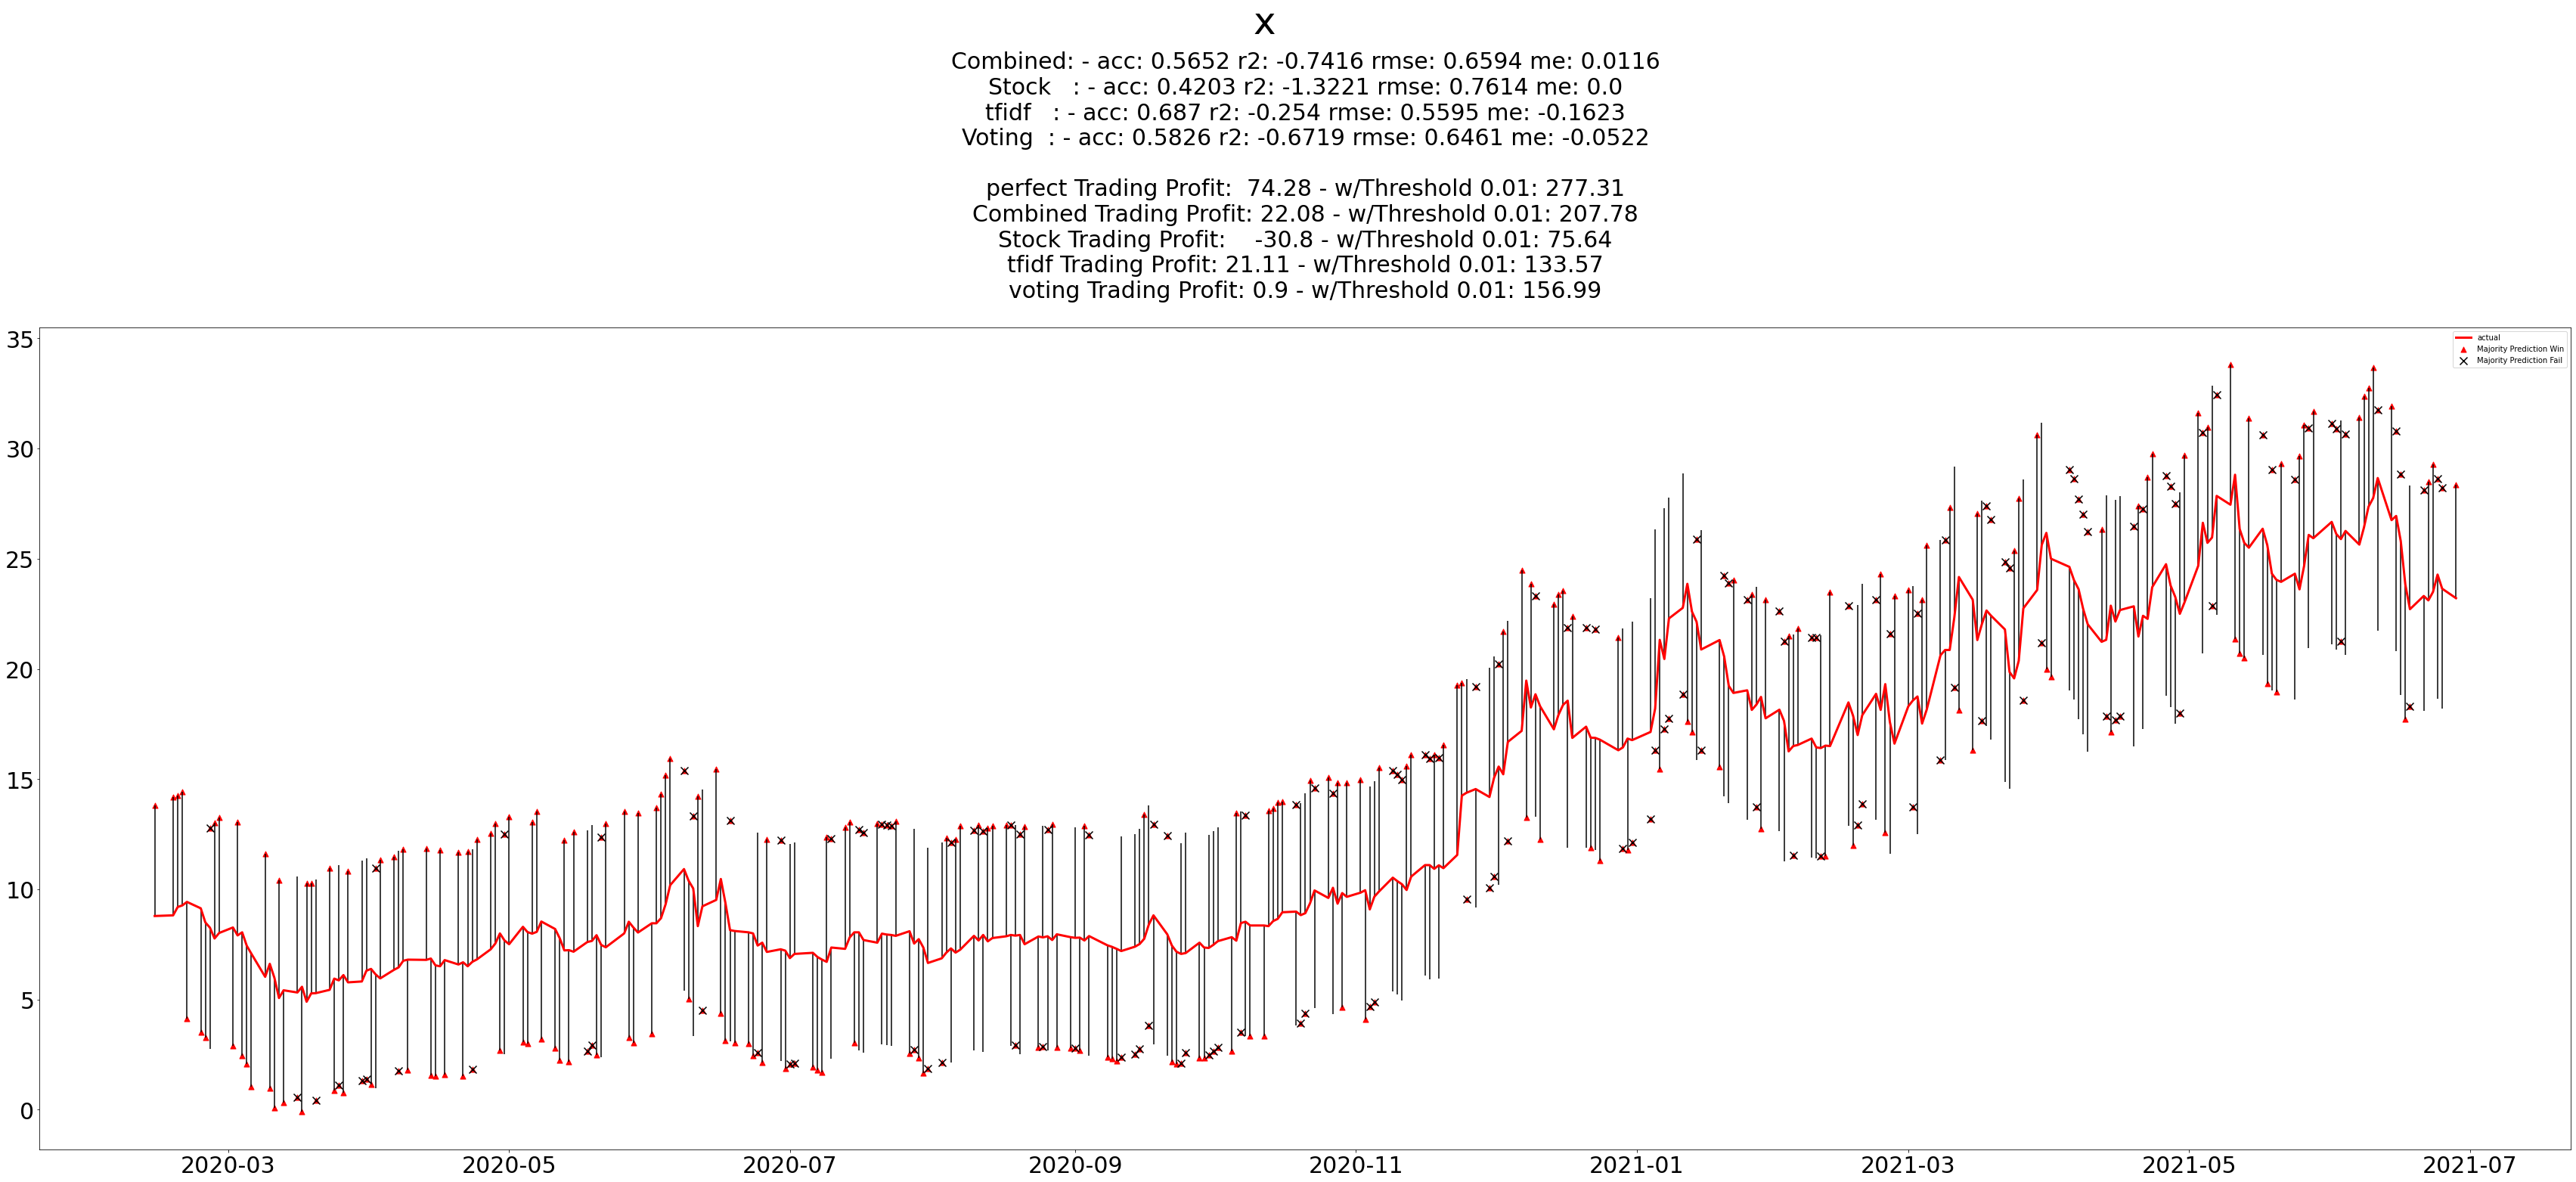

In [20]:
#input_filename = './results/results_amc_1min_MLPRegressor_v1.pkl.zip'
#input_filename = "./results_amc_daily_kmeans_ols.pkl"
#input_filename = "./results/results_all_stocks_LinearRegression_Daily_v1.csv.pkl"
#input_filename = "./results/results_ensemble_Daily_v2.csv.pkl"
#input_filename = "./results/Linear_Regression_Daily_v2.csv.pkl"
input_filename = "./results/Linear_Regression_Daily_all_comments_v1.csv.pkl"

results_df = pd.read_pickle(input_filename)

for group in results_df.groupby('symbol'):
    
    
    loop_df = pd.DataFrame(group[1])
    
    #loop_df = loop_df[loop_df["time"] < pd.to_datetime("2021-01-02")]
    
    #print(loop_df)
    
    model_cols = loop_df.columns[4:]
    
    loop_df['diff'] = pd.Series(loop_df['predict'] - loop_df['actual'])
    
    loop_df['action'] = pd.Series(loop_df['predict'] - loop_df['actual'])
    #//*** Set Negative Values to Zero
    
    loop_df['action'] = loop_df['action'].clip(0)
    #//*** Set Positive Values to 1. Values greater than .0001 are set to .0001 then replaced with 1. Hacky, but functional
    loop_df['action'] = loop_df['action'].clip(0,.0001).replace(.0001,1)
    
    loop_df['plot_action'] = loop_df['action'].replace(0,-5).replace(1,5)+loop_df['predict']

    min_counter=-5
    max_counter=5

    #//*** Loop through the model columns
    for col in model_cols:

    
        loop_df[col.replace("linear_","action_")] = loop_df['predict'] - loop_df[col]
        #//*** Set Negative Values to Zero
        loop_df[col.replace("linear_","action_")] = loop_df[col.replace("linear_","action_")].clip(0)
        #//*** Set Positive Values to 1. Values greater than .0001 are set to .0001 then replaced with 1. Hacky, but functional
        loop_df[col.replace("linear_","action_")] = loop_df[col.replace("linear_","action_")].clip(0,.0001).replace(.0001,1)
        loop_df[col.replace("linear_","plot_")] = loop_df[col.replace("linear_","action_")].replace(0,min_counter).replace(1,max_counter)+loop_df['predict']
        
        min_counter -= 1
        max_counter += 1
    loop_df['action_majority'] = loop_df['action_combined'] + loop_df['action_stock'] + loop_df['action_tfidf']
    #loop_df['acc_combined'] = (loop_df['action'] == loop_df['action_combined']).astype(int)
    #loop_df['acc_stock'] = (loop_df['action'] == loop_df['action_stock']).astype(int)
    #loop_df['acc_tfidf'] = (loop_df['action'] == loop_df['action_tfidf']).astype(int)
    #loop_df['acc_majority'] = loop_df['acc_combined'] + loop_df['acc_stock'] + loop_df['acc_tfidf']
    min_counter=-5
    max_counter=5
    
    loop_df.loc[(loop_df['action_majority'] < 2 ),'action_majority']=0
    loop_df.loc[(loop_df['action_majority'] >= 2),'action_majority']=1
    loop_df['plot_majority'] = loop_df['action_majority'].replace(0,min_counter).replace(1,max_counter)+loop_df['predict']
    loop_df['acc_majority'] = (loop_df['action'] == loop_df['action_majority']).astype(int)
    loop_df['plot_acc_majority'] = loop_df['acc_majority'].replace(1,np.nan) + loop_df['plot_majority']
    #loop_df['plot_acc_win'] = loop_df['acc_majority'].replace(0,np.nan).replace(1,10)+loop_df['predict']
    #loop_df['plot_acc_fail'] = loop_df['acc_majority'].replace(0,-10).replace(1,np.nan)+loop_df['predict']
    
    #print(loop_df.tail(30))
    symbol = group[1]['symbol']
    time = group[1]['time']
    
    #print(loop_df)
    #rmse = group[1]['rmse']
    #r2 = group[1]['r2']
    actual = group[1]['predict']
    #predict = group[1]['predict']

    fig,ax = plt.subplots()

    fig.set_figheight(20)
    fig.set_figwidth(60)

    
    #ax.fill_between(time,group[1]['plot_action'],group[1]['actual'],label='actual_buy/sell',color='black',linewidth=1 )
    
    for x in range(0,len(loop_df)):
        if loop_df.iloc[x]['action'] == 0:
            plt.vlines(loop_df.iloc[x]['time'],loop_df.iloc[x]['plot_action'],loop_df.iloc[x]['actual'])
        else:
            plt.vlines(loop_df.iloc[x]['time'],loop_df.iloc[x]['actual'],loop_df.iloc[x]['plot_action'])
        #ax.plot(x,,color='black',linewidth=1 )
        
    
    ax.plot(loop_df['time'],loop_df['actual'],label='actual',color='red',linewidth=3 )

    #for col in results_df.columns[4:7]:
    #    ax.plot(time,group[1][col],label=col )
    #for col in ['plot_stock','plot_tfidf','plot_combined']:
    #    ax.scatter(time,group[1][col],label=col,s=5 )

    ax.scatter(loop_df['time'],loop_df['plot_majority'],label='Majority Prediction Win',color='red',marker="^",s=50)
    ax.scatter(loop_df['time'],loop_df['plot_acc_majority'],label='Majority Prediction Fail',color='black',marker="x",s=100)
    #ax.scatter(time,group[1]['plot_acc_fail'],label='Accurate Prediction',color='red',marker="x")
    
    linear_combined_r2 = round(r2_score(loop_df['action'],loop_df['action_combined']),4)
    linear_combined_rmse = round(sqrt(mean_squared_error(loop_df['action'], loop_df['action_combined'])),4)
    linear_mean_error = round(get_mean_error(loop_df['action'],loop_df['action_combined']),4)
    linear_combined_acc = round((loop_df['action'] == loop_df['action_combined']).sum() /len(loop_df),4)
    
    linear_stock_r2 = round(r2_score(loop_df['action'],loop_df['action_stock']),4)
    linear_stock_rmse = round(sqrt(mean_squared_error(loop_df['action'], loop_df['action_stock'])),4)
    linear_stock_error = round(get_mean_error(loop_df['action'],loop_df['action_stock']),4)
    linear_stock_acc = round((loop_df['action'] == loop_df['action_stock']).sum() /len(loop_df),4)

    linear_tfidf_r2 = round(r2_score(loop_df['action'],loop_df['action_tfidf']),4)
    linear_tfidf_rmse = round(sqrt(mean_squared_error(loop_df['action'], loop_df['action_tfidf'])),4)
    linear_tfidf_error = round(get_mean_error(loop_df['action'],loop_df['action_tfidf']),4)
    linear_tfidf_acc = round((loop_df['action'] == loop_df['action_tfidf']).sum() /len(loop_df),4)

    majority_r2 = round(r2_score(loop_df['action'],loop_df['action_majority']),4)
    majority_rmse = round(sqrt(mean_squared_error(loop_df['action'], loop_df['action_majority'])),4)
    majority_error = round(get_mean_error(loop_df['action'],loop_df['action_majority']),4)
    majority_acc = round(loop_df['acc_majority'].sum()/len(loop_df),4)
    
    threshold=.01
    title = ""
    title += f"Combined: - acc: {linear_combined_acc} r2: {linear_combined_r2} rmse: {linear_combined_rmse} me: {linear_mean_error}\n"
    title += f"Stock   : - acc: {linear_stock_acc} r2: {linear_stock_r2} rmse: {linear_stock_rmse} me: {linear_stock_error}\n"
    title += f"tfidf   : - acc: {linear_tfidf_acc} r2: {linear_tfidf_r2} rmse: {linear_tfidf_rmse} me: {linear_tfidf_error}\n"
    title += f"Voting  : - acc: {majority_acc} r2: {majority_r2} rmse: {majority_rmse} me: {majority_error}\n\n"
    title += f"perfect Trading Profit:  {calc_pl(loop_df,'actual','action','predict')} - w/Threshold {threshold}: {calc_pl(loop_df,'actual','action','predict',threshold)}\n"
    title += f"Combined Trading Profit: {calc_pl(loop_df,'actual','action_combined','linear_combined')} - w/Threshold {threshold}: {calc_pl(loop_df,'actual','action_combined','linear_combined',threshold)}\n"
    title += f"Stock Trading Profit:    {calc_pl(loop_df,'actual','action_stock','linear_stock')} - w/Threshold {threshold}: {calc_pl(loop_df,'actual','action_stock','linear_stock',threshold)}\n"
    title += f"tfidf Trading Profit: {calc_pl(loop_df,'actual','action_tfidf','linear_tfidf')} - w/Threshold {threshold}: {calc_pl(loop_df,'actual','action_tfidf','linear_tfidf',threshold)}\n"
    title += f"voting Trading Profit: {calc_pl(loop_df,'actual','action_majority','predict')} - w/Threshold {threshold}: {calc_pl(loop_df,'actual','action_majority','predict',threshold)}\n"

    #ax.plot(time,actual)
    #ax.scatter(plot_x,predict,color='red' )
    #ax.plot(plot_x,predict_df['linear'],color='red' )
    plt.suptitle(group[0],fontsize=50,y=1.176)
    plt.title(title,fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.legend()
    plt.show()
    
    